# Paper: [DiffiT: Diffusion Vision Transformers for Image Generation (Nvidia Labs)](https://arxiv.org/pdf/2312.02139)

> Name: Damiano Imola\
> Matricula: 2109063\
> E-mail: imola.2109063@studenti.uniroma1.it

# ℹ Implementation description

In this project I propose an implementation, a grayscale, and a lightweight variants of DiffiT, a paper from NVidia Labs published in 2023 [DiffiT: Diffusion Vision Transformers for Image Generation](https://arxiv.org/abs/2312.02139) that achieve the SOTA result if image generation using a diffusion model with Vision Transformers (ViTs) introducing a novel feature: the Time-Dependent Multi-Head Self-Attention mechanism. DiffiT achieves a new SOTA FID score of 1.73 on ImageNet-256 dataset !

In this implementation I also present a possible lightweight version of the architecture using Depthwise Separable Convolutions and MetaFormers (in particular PoolFormers). The former allows us to decrease the high number of parameters of the architecture without losing so much in accuracy, while the latter is a way to decrease the "high demanding resources" problem of the transformer architecture.

![](https://github.com/damianoimola/diffit/blob/master/assets/facecover.png?raw=true)


## 🔶 The plus one
In addition to the replication of the architecture—a task that has proven to be quite challenging—I have shifted the project towards an **optimization perspective**. I have analyzed various optimization metrics that can be computed for architectures and have undertaken the following modifications:

1. I developed a variant of the DiffiT architecture based on grayscale images. As expected, the performance difference from the RGB version was minimal.

2. I created a new variant, named DiffiP (Diffusion Vision Poolformer 😀), which incorporates the PoolFormer in place of the transformer architecture proposed, moreover, I'll leverage the usage of Depthwise Separable Convolutions. I've tried to leverage the MetaFormer paradigm to optimize our network without (ideally) a big loss in the accurary point of view.

## ❗ Disclaimer
The official GitHub repository of the project doesn't provide any code, as of today (13/06/2023), it is a placeholder for code that will be published in the future.



# 🍳 Initial setup

In [ ]:
!pip install -q torch torchvision datasets transformers lightning thop torchview torchviz torchsummary einops wandb torcheval

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

from PIL import Image
from tqdm.notebook import tqdm
from einops import rearrange

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# torch-related libraries
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchsummary import summary
from torcheval.metrics import FrechetInceptionDistance
# from torchmetrics.image.fid import FrechetInceptionDistance

# lightning
import wandb
import lightning as L
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelSummary, ModelCheckpoint

## Configuration constants and hyperparameters

Let's create a configuration class, in order to handle every hyperparameter, variable and whatever constant we need in the continue of the project. It's a way to centralize parameters and constant value, so to avoid redundancy and improve code maintainability, readability and modulatiry.

In [ ]:
class Configuration:
    ### SETUP
    image_size = 64
    image_channels = 3

    ### TRAINING
    batch_size = 64 #64
    num_epochs = 50
    learning_rate = 1e-3

    ### MODEL
    # default number of channels for multipliers in
    base_channels_dim = 128
    # number timesteps of the diffusion process
    diffusion_timesteps = 16 # 200
    # number of resolution levels
    resolutions = 4
    # number of groups for the group norm operation
    group_norm_groups = 8
    # number of heads for the Multi-Head Attention module
    mha_heads = 4
    # size of heads for the Multi-Head Attention module
    mha_heads_size = 32
    # dimensions in which our patches will be remapped
    hidden_dimension = 64 # 256
    # number of patch-per-side, for images to feed them in transformer
    patches_number = 2
    # number of consecutive transformer block
    num_transformer_blocks = 1
    # MLP increase multiplier for Vision Transformer's feature sequential model
    mlp_ratio = 4
    # Time MLP increase multiplier for time sequential model
    time_mlp_ratio = 2 # 4
    # number of residual blocks each level
    per_level_residual_blocks = (1, 1, 1, 1)

    ### CHECKPOINTS
    checkpoint_dir_name = 'checkpoint/'

    ### GENERAL
    seed = 42
    debug = False
    log = False
    notebook_default_dir = "" # "/kaggle/working/"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    workers = len(os.sched_getaffinity(0))


config = Configuration()

In [ ]:
#@title Turn on the "Hard mode"
hard_mode = False
if hard_mode:
    config.patches_number = 8
    config.per_level_residual_blocks = (4, 4, 4, 4)
    config.num_transformer_blocks = 2
    config.hidden_dimension = 256
    config.time_mlp_ratio = 4

In [ ]:
def set_global_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    seed_everything(seed)

set_global_seed(config.seed)

INFO: Seed set to 42


In [ ]:
debug = config.debug
device = config.device
default_dir = config.notebook_default_dir
timesteps = config.diffusion_timesteps

In [ ]:
tiny_imagenet_zip_path = "tiny-imagenet-200.zip"
tiny_imagenet_dir_path = "tiny-imagenet-200"

if not os.path.exists(tiny_imagenet_zip_path):
    !wget https://www.image-net.org/data/tiny-imagenet-200.zip

if not os.path.exists(tiny_imagenet_dir_path):
    !unzip -q tiny-imagenet-200.zip -d tiny-imagenet-200

directory = default_dir + "lightning_logs"
if not os.path.exists(directory):
    !mkdir {directory}

directory = default_dir + "checkpoint"
if not os.path.exists(directory):
    !mkdir {directory}

# 🧰 Assembly model

## Architecture

The DiffiT architecture is the following



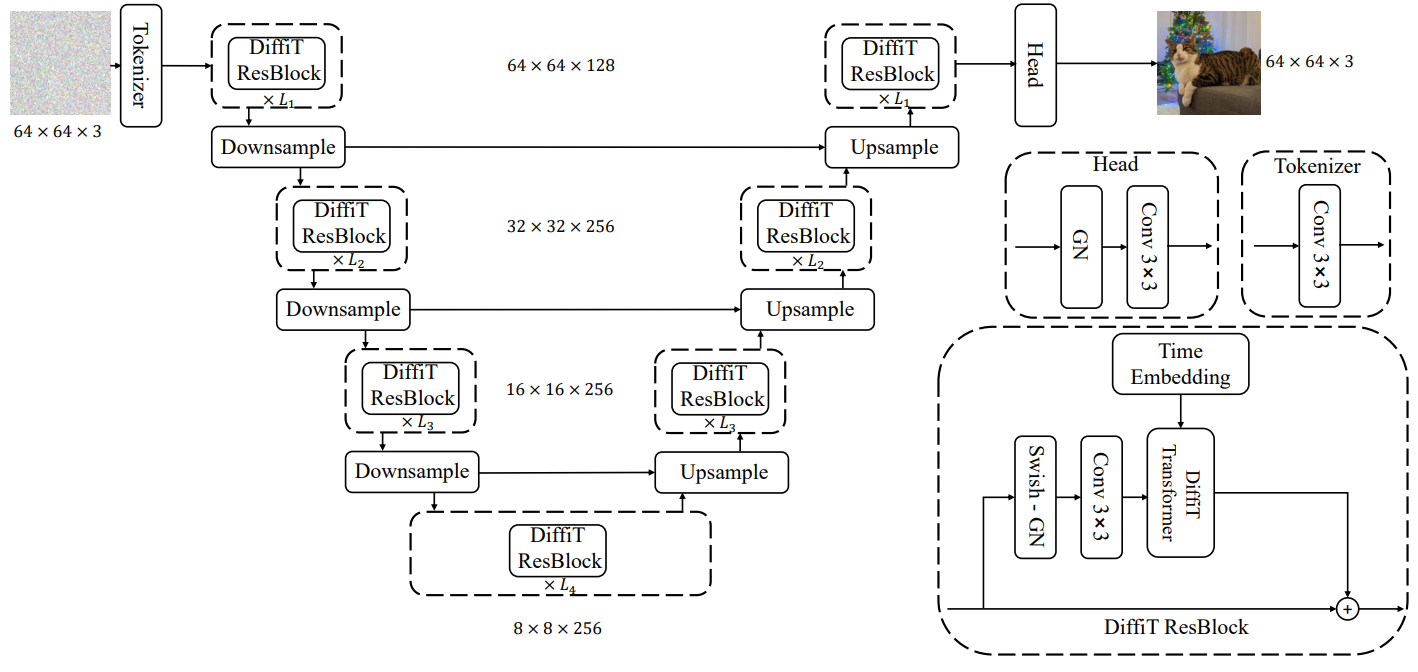

## Positional Time Embedding

Positional embeddings are meant to store the position of image's patches, like in the following example: this is the image 🐱 I'll use to show this example

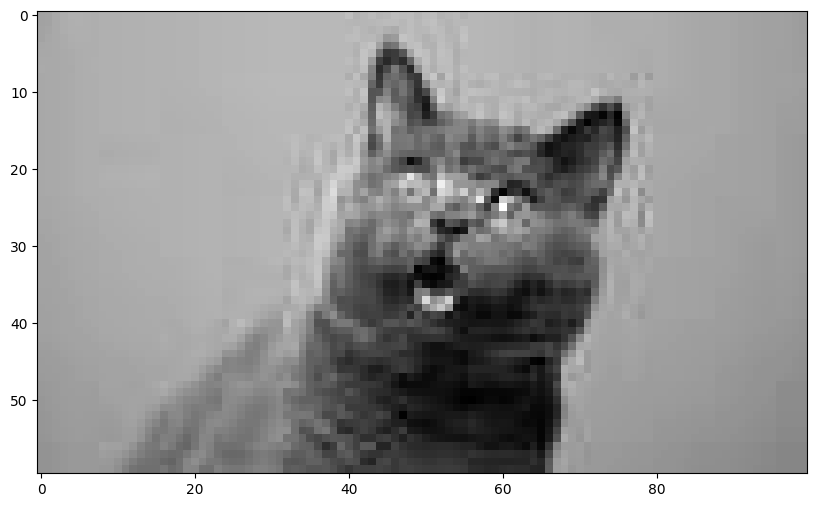




dividing it in patches, and assigning to each of them a positional embeddings, the image will look like the following

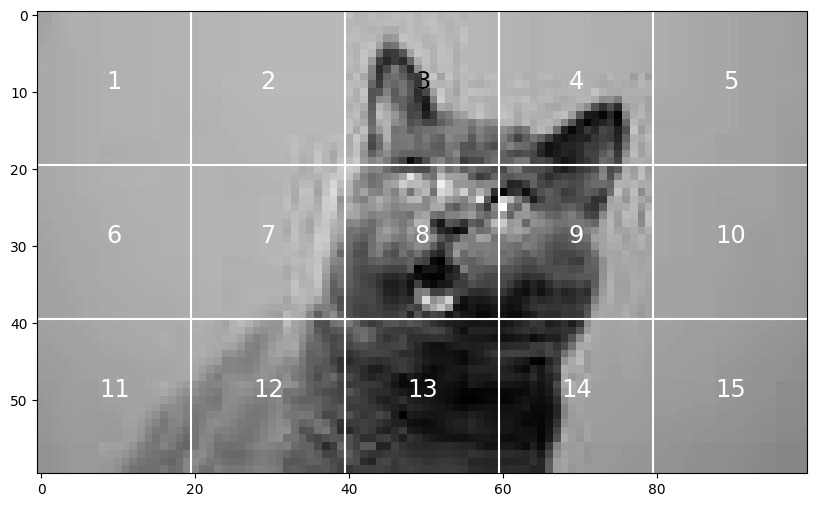


and since we are storing the position of each patch, also scrumbling 🔀 them, we are able to recover their position

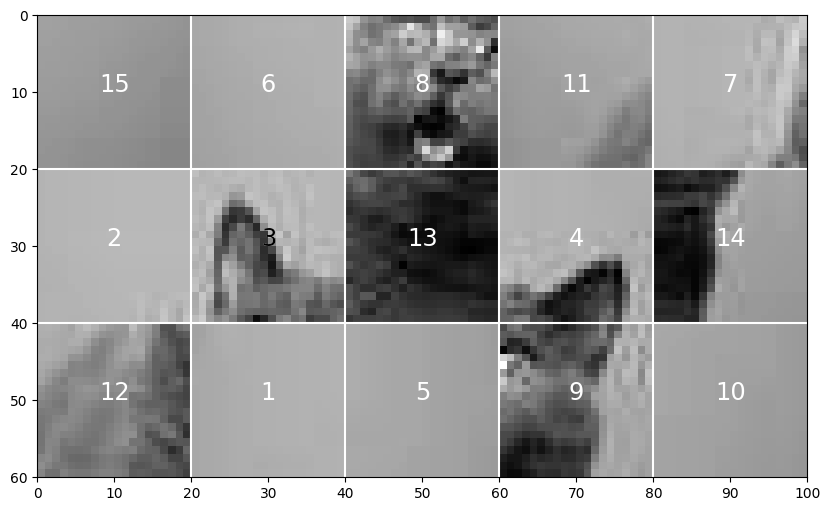

Authors of DiffiT does not specify which kind of positional embeddings they are using. Anyway, in order to do not increase the computational complexity of the model but maintaining good performances, the class of **Sinusoidal Positional embeddings** are good options (towards the end there will be an analysis on which are other types of embeddings that we could and couldn't use).

Let $t$ be the desired position in an input sequence $S$, let $\vec{p}_t\in\mathbb{R}^d$ be the corresponding encoding and $d$ the encoding dimension (with $d\equiv_20$). Then $f:\mathbb{N}\rightarrow\mathbb{R}^d$ is the function that produces the output vector $\vec{p}_t$ and is defined as follows

$$
\vec{p}_t^{(i)}=f(t)^{(i)} = \sin(\omega_k \cdot t),\quad \text{if }i=2k\\
\vec{p}_t^{(i)}=f(t)^{(i)} = \cos(\omega_k \cdot t),\quad \text{if }i=2k+1\\
$$
where
$$
w_k=\dfrac{1}{10000^{2k/d}}
$$
s it can be derived from the function definition, the frequencies are decreasing along the vector dimension; it forms a geometric progression from $2\pi$ to $10000*2\pi$ on the wavelengths.

Therefore we obtain the following positional embedding vector
$$
\vec{p}_t = \bigg[\sin(\omega_1 \cdot t),\; \cos(\omega_1 \cdot t),\; \sin(\omega_2 \cdot t),\; \cos(\omega_2 \cdot t),\; \dots,\;  \sin(\omega_{d/2} \cdot t),\; \cos(\omega_{d/2} \cdot t)\bigg]^\top
$$

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

the following code will show you an application of the former **SinusoidalPositionEmbeddings** class to a random array and to an array with numbers linearly increasing.

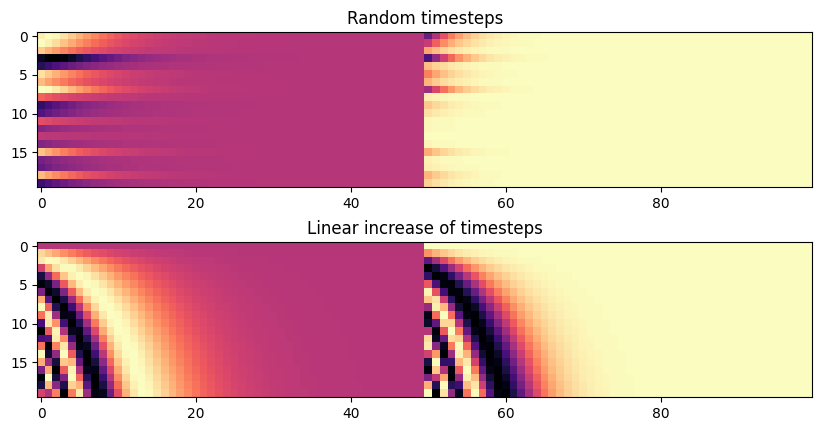

In [ ]:
# check for correctness
spe = SinusoidalPositionEmbeddings(100)

# the input should be a vector of dimension (B, 1) (i.e. batch_size x 1)
rand_res = spe(torch.randn(20))
lin_res = spe(torch.arange(20))

# it generates an embedding of dimension 100 for each of 20 elements in the input
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

ax = axes[0]
ax.set_title("Random timesteps")
ax.imshow(rand_res, cmap='magma')

ax = axes[1]
ax.set_title("Linear increase of timesteps")
ax.imshow(lin_res, cmap='magma')

## Head & Tokenizer



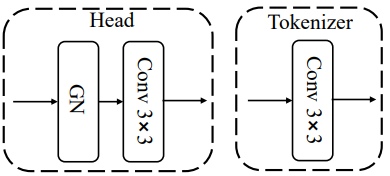

In [ ]:
class Head(nn.Module):
    def __init__(self, dim_in, dim_out, conv_class=nn.Conv2d, gn_groups=config.group_norm_groups):
        super(Head, self).__init__()
        self.gn = nn.GroupNorm(gn_groups, dim_in)                                       # B*128*64*64 -> B*128*64*64
        self.swish = nn.SiLU()
        self.conv = conv_class(dim_in, dim_out, kernel_size=3, stride=1, padding=1)      # B*128*64*64 -> B*3*64*64

    def forward(self, x, t):
        x = self.gn(x)
        x = self.swish(x)
        x = self.conv(x)
        return x

class Tokenizer(nn.Module):
    def __init__(self, dim_in, dim_out, conv_class=nn.Conv2d):
        super(Tokenizer, self).__init__()
        self.conv = conv_class(dim_in, dim_out, kernel_size=3, stride=1, padding=1)      # B*3*64*64 -> B*128*64*64

    def forward(self, x, t):
        x = self.conv(x)
        return x

## Vision Transformer (TMSA + MLP)

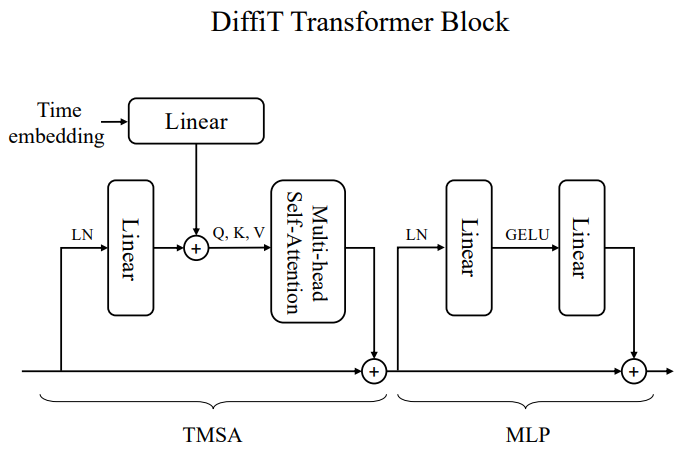

## ⏲ Time-dependend multi-head self-attention

This is the Time-dependent multi-head self-attention module of the architecture, in other words, the core. This block is responsible for leading the S.O.T.A. performance in the image generation tasks.

It allows the transformer to **gather spatio-temporal informations** regarding input data, thanks to its time dependency. Let $x_s$ and $x_t$ respectively the spatial and temporal embeddings. The attention module's Query, Key and Values are defined as follows:

$$
q_s = x_s W_{qs} + x_t W_{qt}\\
k_s = x_s W_{ks} + x_t W_{kt}\\
v_s = x_s W_{vs} + x_t W_{vt}\\
$$

where $W_{qs}, W_{qt}, W_{ks}, W_{kt}, W_{vs}$ and $W_{vt}$ denote spatial (i.e. the ones with subscript $_{*s}$) and temporal (i.e. the ones with subscript $_{*t}$) projection weights for their corresponding queries, keys, and values respectively.

<h2>Attention with relative-position bias</h2>

Denoting $Q=\{q_s\}, K=\{k_s\}, V=\{v_s\}$, the self-attention will be computed as always, but with ad addition in the pre-softmax operation:

$$\text{Attention}(Q, K, V) = \text{Softmax}\left(\dfrac{QK^\top}{\sqrt{d}}+B\right)\cdot V$$

where $B$ is the so called *relative position bias*: introduced by Peter Shaw in [Self-Attention with Relative Position Representations, (2018)](https://arxiv.org/abs/1803.02155), it extends the self-attention mechanism to efficiently consider representation of the relative position (or distances) between sequence elements.

**OBSERVATION**: in CNNs this mechanism is intrinsic in the convolution operation, it captures relative positions within the kernel size of each convolution.


<h2>First optimization</h2>

since in general handling images is a memory-intensive task, I've used the implementation of the Relative Position Representations in an optimized way, i.e. using the *memory-efficient "skewing"* procedure.\
Details about the implementation of the optimized skew-symmetrization process are described in [Music Transformer, (2018), figure 1](https://arxiv.org/abs/1809.04281); anyway, the final optimized formula to compute the relative Attention is:
$$\text{Attention}(Q, K, V) = \text{Softmax}\left(\dfrac{QK^\top + S^{rel}}{\sqrt{d}}\right)\cdot V$$

<h2>❗ The big result</h2>

The initial equations listed above are equivalent to linear projection of each spatial token summated with linear projection of each time token. As a result, **Query, Key and Values** are are all **linear functions** of both time and spatial tokens.

This is a really good thing, since in this way, Query, Key and Values can modify their behavious adaptively according to the timestep!

In other words, *attention module can learn to act differently based on the timestep in which diffusion process is* 🙂.

In [ ]:
class TDMHSA(nn.Module):
    def __init__(self, feature_dim, time_dim, n_heads, max_len=1024):
        super(TDMHSA, self).__init__()
        self.feature_dim = feature_dim
        self.time_dim = time_dim
        self.num_heads = n_heads
        self.max_len = max_len

        assert feature_dim % n_heads == 0, f"Can't divide dimension spatial {feature_dim} into {n_heads} heads"
        assert time_dim % n_heads == 0, f"Can't divide dimension time {time_dim} into {n_heads} heads"

        # computing head dimension
        spatial_head_dim = int(feature_dim / n_heads)
        time_head_dim = time_dim #int(time_dim / n_heads)

        self.spatial_head_dim = spatial_head_dim
        self.time_head_dim = time_head_dim

        # spatial mappings
        self.qs_projections = nn.Linear(feature_dim, feature_dim)
        self.ks_projections = nn.Linear(feature_dim, feature_dim)
        self.vs_projections = nn.Linear(feature_dim, feature_dim)

        # time mappings
        self.qt_projections = nn.Linear(time_dim, feature_dim)
        self.kt_projections = nn.Linear(time_dim, feature_dim)
        self.vt_projections = nn.Linear(time_dim, feature_dim)

        self.softmax = nn.Softmax(dim=-1)

        # relative positional bias
        self.Er = nn.Parameter(torch.randn(max_len, spatial_head_dim))


    def forward(self, patches, time_emb):
        if debug: print("pathes size", patches.size())
        if debug: print("time emb size", time_emb.size())
        # input size = [batch size, query len, hid dim]
        batch_size, seq_length, embed_dim = patches.size()

        # spatial Q, K, V
        #Q, K, V shape = [batch size, query len, hid dim]
        qs = self.qs_projections(patches)
        ks = self.ks_projections(patches)
        vs = self.vs_projections(patches)

        # temporal Q, K, V
        #Q, K, V shape = [batch size, query len, hid dim]
        qt = self.qt_projections(time_emb)
        kt = self.kt_projections(time_emb)
        vt = self.vt_projections(time_emb)


        # split hidden dimension between heads
        # Q, K, V shape = [batch size, n heads, query len, head dim]
        qs = qs.view(batch_size, seq_length, self.num_heads, self.spatial_head_dim).permute(0, 2, 1, 3)
        ks = ks.view(batch_size, seq_length, self.num_heads, self.spatial_head_dim).permute(0, 2, 1, 3)
        vs = vs.view(batch_size, seq_length, self.num_heads, self.spatial_head_dim).permute(0, 2, 1, 3)

        qt = qt.view(batch_size, 1, self.num_heads, self.spatial_head_dim).permute(0, 2, 1, 3)
        kt = kt.view(batch_size, 1, self.num_heads, self.spatial_head_dim).permute(0, 2, 1, 3)
        vt = vt.view(batch_size, 1, self.num_heads, self.spatial_head_dim).permute(0, 2, 1, 3)


        # time-dependent Q, K, V
        q, k, v = qs+qt, ks+kt, vs+vt


        # computing relative positional bias
        # implementation -> jaketae.github.io/study/relative-positional-encoding/
        start = self.max_len - seq_length
        Er_t = self.Er[start:, :].transpose(0, 1)
        QEr = torch.matmul(qs, Er_t)
        Srel = self.skew(QEr)


        # attention scores
        scores = (torch.matmul(q, k.permute(0, 1, 3, 2)) + Srel) / (self.spatial_head_dim ** 0.5)

        # attention weights
        attention_weights = F.softmax(scores, dim=-1)

        # apply attention weights to values
        attention_output = torch.matmul(attention_weights, v)

        # concat and project back to the original embedding dimension
        attention_output = attention_output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * self.spatial_head_dim)

        return attention_output


    def skew(self, QEr):
        padded = F.pad(QEr, (1, 0))
        batch_size, num_heads, num_rows, num_cols = padded.shape
        reshaped = padded.reshape(batch_size, num_heads, num_cols, num_rows)
        Srel = reshaped[:, :, 1:, :]
        return Srel


Let's test if the Time-Dependent Multi-Head Self-Attention transformer with relative position bias works. In general we cannot say "Oh yes, now it works" but we can check if the returning value is the expected one: the initial shape should be the same as the final one.

In [ ]:
def test():
    feature_dim = 128
    time_dim = 64
    n_heads = 4
    max_seq_len = 10
    batch_size = 32

    patches = torch.randn(batch_size, 4, feature_dim)
    time_emb = torch.randn(batch_size,  time_dim)

    # applying
    tdmhsa = TDMHSA(feature_dim, time_dim, n_heads)
    output = tdmhsa(patches, time_emb)

    print("Input shape:", patches.shape)
    print("Output shape:", output.shape)
test()

Input shape: torch.Size([32, 4, 128])
Output shape: torch.Size([32, 4, 128])


## Vision Transformer Block (i.e. Diffit Transformer Block)

In [ ]:
class VisionTransformerBlock(nn.Module):
    def __init__(self, time_emb_dim, hidden_dim, num_heads, mlp_ratio):
        super(VisionTransformerBlock, self).__init__()

        # tmsa
        self.norm = nn.LayerNorm(hidden_dim)
        self.tdmhsa = TDMHSA(hidden_dim, time_emb_dim, num_heads).to(device)

        # mlp
        self.mlp = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, mlp_ratio * hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_dim, hidden_dim)
        )

        self.relu = nn.ReLU()

    def forward(self, x, t):
        out = x + self.tdmhsa(self.norm(x), t)

        out = out + self.mlp(out)
        return self.relu(out)


## Diffusion Vision Transformer


The general architecture for Diffusion Vision Transformer (DiT) has been built following these three papers:

*   [U-DiT TTS: U-Diffusion Vision Transformer for Text-to-Speech, 2023](https://arxiv.org/pdf/2305.13195.pdf)
*   [An image is worth 16$\times$16 words: transformers for image recognition at scale, 2021](https://arxiv.org/pdf/2010.11929.pdf)
*   [Vision Transformers for Remote Sensing Image Classification, 2021](https://www.researchgate.net/publication/348947034_Vision_Transformers_for_Remote_Sensing_Image_Classification)

follows an hand made image of the architectures coming from these papers.


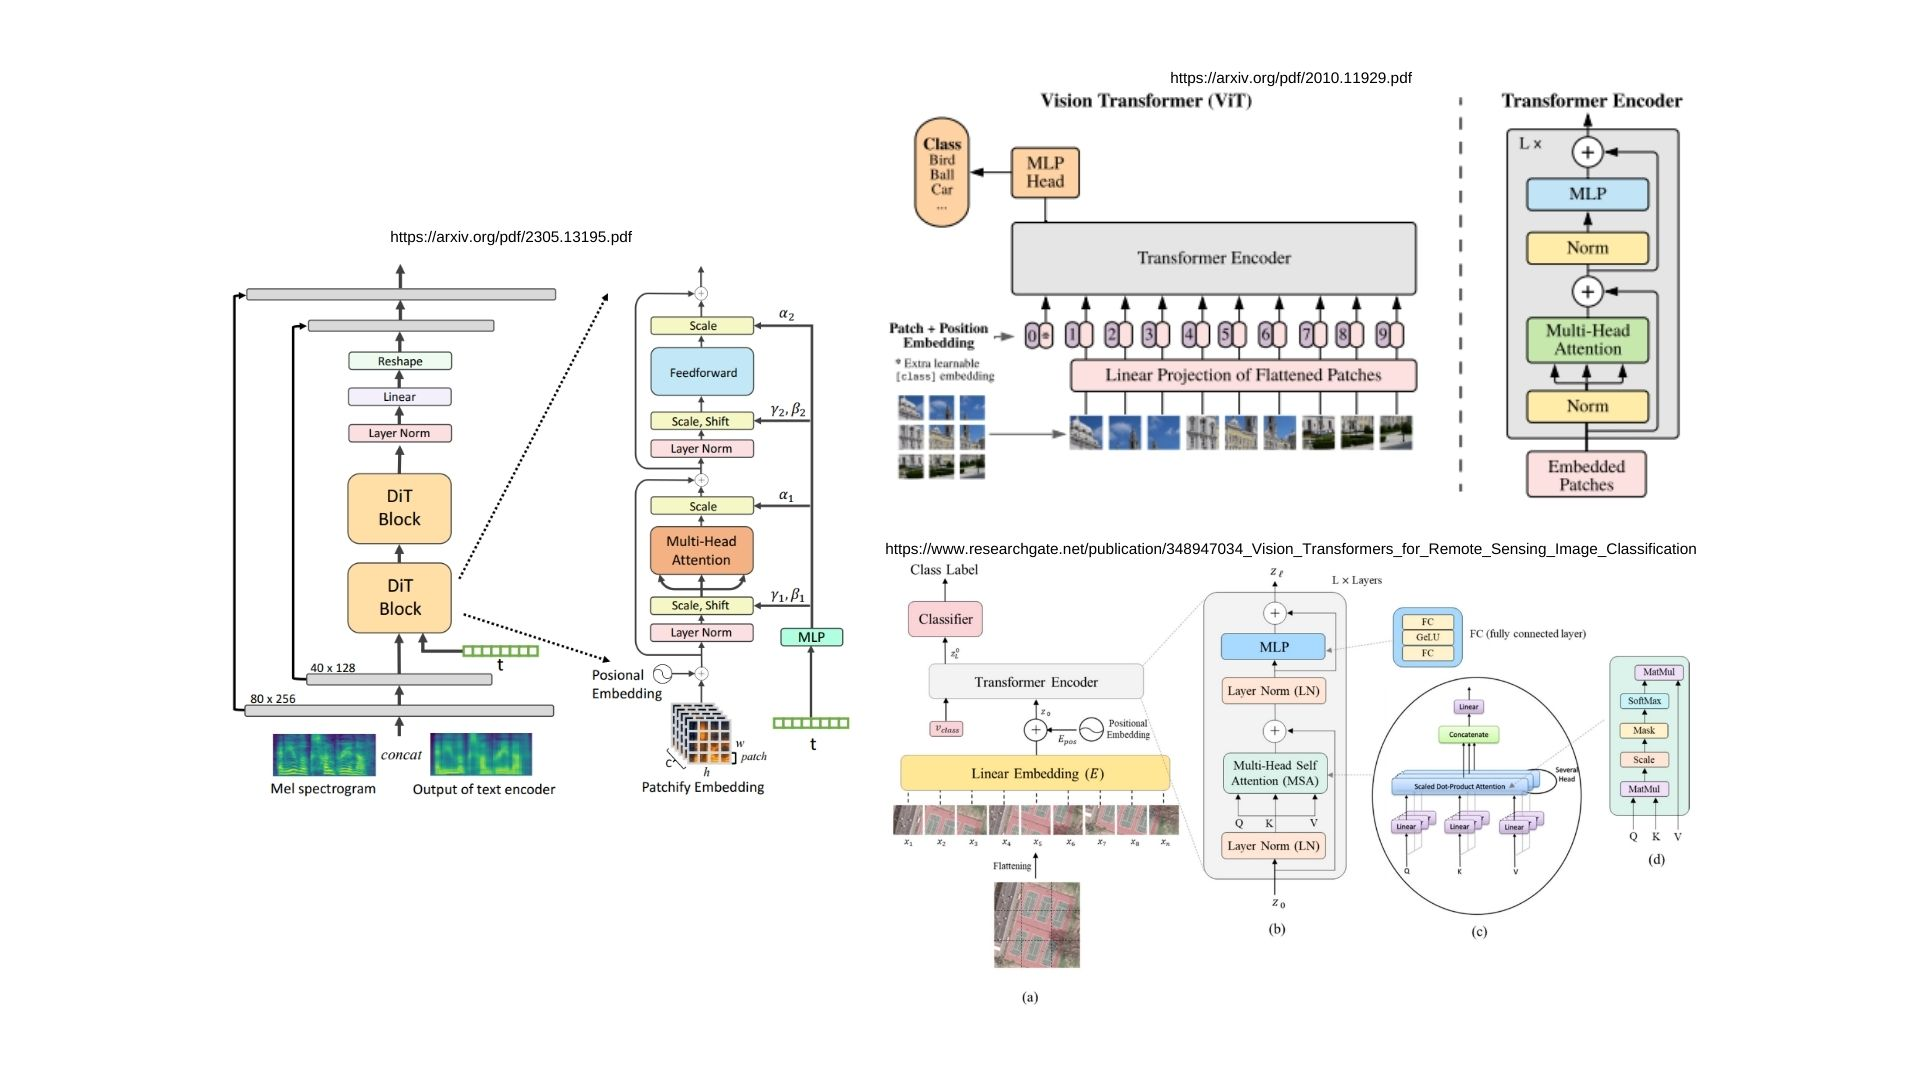

The steps of the vision transformer are commented in the following class

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self,
                 dim_in,
                 dim_out,
                 time_emb_dim,
                 image_dimension,
                 hidden_dim=config.hidden_dimension,
                 num_patches=config.patches_number,
                 num_heads=config.mha_heads,
                 num_blocks=config.num_transformer_blocks,
                 mlp_ratio=config.mlp_ratio,
                 vit_block_class=VisionTransformerBlock
        ):
        super(VisionTransformer, self).__init__()
        self.num_patches = num_patches
        # self.data_shape = (dim_in, image_dimension, image_dimension)

        c, h, w = (dim_in, image_dimension, image_dimension)

        # computing patch size
        assert h % num_patches == 0, f"Input height {h} not entirely divisible by number of patches {num_patches}"
        assert w % num_patches == 0, f"Input width {w} not entirely divisible by number of patches {num_patches}"
        self.patch_size = (h/num_patches, w/num_patches)

        # 1) initial linear map
        self.input_d = int(c * self.patch_size[0] * self.patch_size[1]) # = 3*8*8 = 192
        if debug: print(f"dims{image_dimension}*{image_dimension}, num_patches {num_patches}, patch {self.patch_size[0]}*{self.patch_size[1]}, channels {c}, total {self.input_d}")
        self.initial_linear_layer = nn.Linear(self.input_d, hidden_dim) # 192 -> 32

        # 2) per-patch positional embedding
        pos_emb = self.get_positional_embeddings(num_patches ** 2, hidden_dim)
        # self.pos_embed = nn.Parameter(torch.tensor(pos_emb)) # (num_patches ** 2, 32) = (64, 32)
        self.pos_embed = nn.Parameter(pos_emb.clone().detach().requires_grad_(True))
        self.pos_embed.requires_grad = False

        # 3) tmsa + mlp = vit block
        self.vit_blocks = nn.ModuleList(
            [vit_block_class(time_emb_dim, hidden_dim, num_heads, mlp_ratio)
            for _ in range(num_blocks)]
        )

        # 4) final linear map
        self.final_layer_norm = nn.LayerNorm(hidden_dim) # 32 -> 192
        self.final_linear_layer = nn.Linear(hidden_dim, self.input_d) # 32 -> 192

        # 5) OPTIONAL: 1x1 convolution for channels alignment
        self.align = nn.Conv2d(dim_in, dim_out, kernel_size=1) if (dim_in != dim_out) else nn.Identity()




    def forward(self, images, time_embeddings):
        b, c, h, w = images.shape

        # 64x64 image in 8 patch per side -> 8*8=64 patches in total, each of size 8*8*3=64*3=192
        if debug: print("pre patch", images.size())
        patches = self.patchify(images, self.num_patches, images.shape) # (B, 3, 64, 64) -> (B, 64, 192)
        if debug: print("post patch", patches.size())
        tokens = self.initial_linear_layer(patches) # (B, 64, 192) -> (B, 64, 32)

        # adding positional patch embedding
        pos_embed = self.pos_embed.repeat(images.size()[0], 1, 1) # (64, 32) -> (B, 64, 32)
        out = tokens + pos_embed # (B, 64, 32) -> (B, 64, 32)
        if debug: print("post add", out.size())

        # transformer blocks
        if debug: print(out.size())
        for block in self.vit_blocks:
            out = block(out, time_embeddings) # (B, 64, 32) -> (B, 64, 32)

        # reconstructing stage
        out = self.final_layer_norm(out) # (B, 64, 32) -> (B, 64, 32)
        if debug: print("post fin norm", out.size())
        out = self.final_linear_layer(out) # (B, 64, 32) -> (B, 64, 192)
        if debug: print("post fin lin", out.size())

        # patches to images
        original_images = self.depatchify(out, self.num_patches, images.shape) # (B, 64, 192) -> (B, 3, 64, 64)
        if debug: print("post depatch", original_images.size())

        return self.align(original_images)




    # from original image to patches
    def patchify(self, images, num_patches, data_shape):
        b, c, h, w = data_shape

        patches = torch.zeros(b, num_patches**2, h*w*c//num_patches**2).to(device)
        patch_size = h // num_patches

        for idx, image in enumerate(images):
            for i in range(num_patches):
                for j in range(num_patches):
                    row_indices = slice(i*patch_size, (i+1)*patch_size)
                    col_indices = slice(j*patch_size, (j+1)*patch_size)
                    patch = image[:, row_indices, col_indices]

                    # vectorized array of patches
                    patches[idx, i*num_patches+j] = patch.flatten()
        return patches




    # from patches to original image
    def depatchify(self, patches, num_patches, data_shape):
        b, c, h, w = data_shape
        # b, c, h, w = self.b, self.c, self.h, self.w

        images = torch.zeros(b, c, h, w).to(device)

        for idx, image_patches in enumerate(patches):
            for i in range(num_patches):
                for j in range(num_patches):
                    patch = image_patches[i*num_patches+j]
                    patch = patch.reshape(c, h//num_patches, w//num_patches)

                    row_indices = slice(i*h//num_patches, (i+1)*h//num_patches)
                    col_indices = slice(j*w//num_patches, (j+1)*w//num_patches)

                    images[idx, :, row_indices, col_indices] = patch
        return images




    # patches positional embeddings
    def get_positional_embeddings(self, sequence_length, d):
        result = torch.ones(sequence_length, d)
        for i in range(sequence_length):
            for j in range(d):
                result[i][j] = np.sin(i/(10_000**(j/d))) if j%2==0 else np.cos(i/(10_000**((j-1)/d)))
        return result

## Residual DiffiT Block



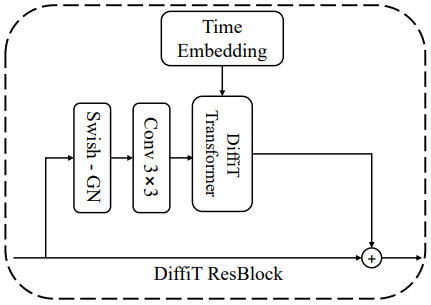

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, time_emb_dim, image_shape, conv_class=nn.Conv2d, vit_block_class=VisionTransformerBlock):
        # dim_in=128, dim_out=128, time_emb_dim=256
        super(ResBlock, self).__init__()
        self.swish = nn.SiLU()
        self.swish2 = nn.SiLU()
        self.gn = nn.GroupNorm(config.group_norm_groups, dim_in)
        self.conv = conv_class(dim_in, dim_in, kernel_size=3, stride=1, padding=1) # HxWxKin -> HxWxKout (i.e. no shape change)
        self.transformer = VisionTransformer(dim_in, dim_in, time_emb_dim, image_shape, vit_block_class=vit_block_class).to(device)
        self.resize = conv_class(dim_in, dim_out, kernel_size=1, stride=1, padding=0) if dim_in != dim_out else nn.Identity()

    def forward(self, x, t):
        # B*128*64*64 + B*256
        residual = x

        x = self.gn(x)
        x = self.swish(x)
        x = self.conv(x)

        x = self.transformer(x, t)
        x = x + residual
        x = self.swish2(x)
        return self.resize(x)

## Down/Up sampling and Resizing layers

In [ ]:
class Downsampling(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size=3, stride=2, padding=1):
        super(Downsampling, self).__init__()
        self.conv = nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x, t=None):
        if debug: print("PRE-DOWN", x.size())
        x = self.conv(x)
        if debug: print("POST-DOWN", x.size())
        return x


class Upsampling(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size=4, stride=2, padding=1):
        super(Upsampling, self).__init__()
        self.conv = nn.ConvTranspose2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x, t=None):
        if debug: print("PRE-UP", x.size())
        x = self.conv(x)

        if debug: print("POST-UP", x.size())
        return x

class Resizing(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Resizing, self).__init__()
        self.dim_in, self.dim_out = dim_in, dim_out
        self.conv = nn.Conv2d(dim_in, dim_out, kernel_size=1)

    def forward(self, x, t=None):
        if debug: print("PRE-RES", x.size(), self.dim_in, self.dim_out)
        x = self.conv(x)
        if debug: print("POST-RES", x.size())
        return x

## Put all together

In [ ]:
class DiffiT(nn.Module):
    def __init__(self,
                 image_shape, # (C, H, W)
                 base_dim,
                 resolutions_list,
                 num_resolutions,
                 num_res_blocks,
                 residual_connection_level,
                 time_mlp_ratio=config.time_mlp_ratio,
                 vit_block_class=VisionTransformerBlock,
                 downsampling_class=Downsampling,
                 upsampling_class=Upsampling
        ):
        super(DiffiT, self).__init__()

        self.downsampling_class = downsampling_class
        self.upsampling_class = upsampling_class

        # list of input-output resolutions
        dim_in_out = self.compute_per_layer_channels(base_dim, image_shape[0])

        # time positional embedding
        dim = config.image_size
        time_emb_dim = dim * time_mlp_ratio
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),      # B*1 -> B*64
            nn.Linear(dim, time_emb_dim),           # B*64 -> B*256
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),  # B*256 -> B*256
        ).to(device)



        ##### FIRST HALF - decreasing resolution
        # tokenizer/downsampling + ResBlock
        self.downward_layers = nn.ModuleList([])
        for i in range(num_resolutions-1):
            # channels at this resolution
            dim_in = dim_in_out[0][i][0]
            dim_mid = dim_in_out[0][i][1]
            dim_out = dim_in_out[0][i][2]

            if(i==0):
                self.downward_layers.append(Tokenizer(dim_in, dim_mid, downsampling_class).to(device))
            else:
                self.downward_layers.append(downsampling_class(dim_in, dim_mid).to(device))

            # add right amount of layers
            for j in range(num_res_blocks[i]):
                # if last residual block: downscale
                if j == num_res_blocks[i]-1:
                    self.downward_layers.append(ResBlock(dim_mid, dim_out, time_emb_dim, resolutions_list[i], downsampling_class, vit_block_class).to(device))
                # else maintain same size
                else:
                    self.downward_layers.append(ResBlock(dim_mid, dim_mid, time_emb_dim, resolutions_list[i], downsampling_class, vit_block_class).to(device))




        ##### BOTTLENECK
        self.bottleneck_layers = nn.ModuleList([])
        self.bottleneck_layers.append(downsampling_class(dim_in_out[1][0], dim_in_out[1][1]).to(device))
        for j in range(num_res_blocks[-1]):
            # if last residual block: downscale
            if j == num_res_blocks[i]-1:
                self.bottleneck_layers.append(ResBlock(dim_in_out[1][1], dim_in_out[1][2], time_emb_dim, resolutions_list[-1], downsampling_class, vit_block_class).to(device))
            # else maintain same size
            else:
                self.bottleneck_layers.append(ResBlock(dim_in_out[1][1], dim_in_out[1][1], time_emb_dim, resolutions_list[-1], downsampling_class, vit_block_class).to(device))
        self.bottleneck_layers.append(upsampling_class(dim_in_out[1][2], dim_in_out[1][3]).to(device))



        ##### SECOND HALF - increasing resolution
        self.resizing_layers = nn.ModuleList([])
        for i in range(num_resolutions-1):
            from_dim = dim_in_out[0][i][1]
            to_dim = dim_in_out[2][i][1]
            if debug: print(f"{from_dim} --> {to_dim}")
            self.resizing_layers.append(Resizing(dim_in_out[0][i][1], dim_in_out[2][i][1]).to(device))



        # ResBlock + downsampling/head
        self.upward_layers = nn.ModuleList([])
        for i in range(num_resolutions-1):
            # channels at this resolution
            dim_in = dim_in_out[2][i][0]
            dim_mid = dim_in_out[2][i][1]
            dim_out = dim_in_out[2][i][2]

            # add right amount of layers
            for j in range(num_res_blocks[i]):
                # if last residual block: downscale
                if j == num_res_blocks[i]-1:
                    self.upward_layers.append(ResBlock(dim_in, dim_mid, time_emb_dim, np.flip(resolutions_list)[i+1], downsampling_class, vit_block_class).to(device))
                # else maintain same size
                else:
                    self.upward_layers.append(ResBlock(dim_in, dim_in, time_emb_dim, np.flip(resolutions_list)[i+1], downsampling_class, vit_block_class).to(device))

            if(i==num_resolutions-1-1): # i.e. last iteration
                self.upward_layers.append(Head(dim_mid, dim_out, downsampling_class).to(device))
            else:
                self.upward_layers.append(upsampling_class(dim_mid, dim_out).to(device))

        self.act = nn.ReLU()



    def forward(self, x, time):
        time = time.to(config.device)
        x = x.to(config.device)
        t = self.time_mlp(time) # B*1 -> B*256
        if debug: print(x.size(), time.size())
        h = []

        # downward side
        for i, l in enumerate(self.downward_layers):
            if debug: print("DOWN -", i, type(l))
            x = l(x, t)
            if isinstance(l, self.downsampling_class):
                h.append(x)

        # bottleneck
        for i, l in enumerate(self.bottleneck_layers):
            if debug: print("BOTTLENECK -", i, type(l))
            if isinstance(l, self.upsampling_class):
                x = x + h.pop()
            x = l(x, t)

            if isinstance(l, self.downsampling_class):
                h.append(x)

        # upward side
        counter = 0
        for i, l in enumerate(self.upward_layers):
            if debug: print("UP -", i, type(l))
            if isinstance(l, self.upsampling_class):# and res:
                skip = h.pop()
                # channel comparison
                if((x.size()[1] != skip.size()[1])):
                    if debug: print(f"RESIZE {skip.size()[1]} --> {x.size()[1]}")
                    skip = self.resizing_layers[counter](skip)
                    if debug: print(f"AFTER RESIZE {skip.size()[1]} == {x.size()[1]}")
                    x = x + skip
                else:
                    x = x + skip
                counter+=1
                x = self.act(x)
                # x = F.relu(x)
            x = l(x, t)

        return x


    def compute_per_layer_channels(self, base_dim, image_channels):
        # list of input-output resolutions
        downward_dims_in = [image_channels, *map(lambda m: base_dim * m, (1, 2))]
        downward_dims_downsample = [*map(lambda m: base_dim * m, (1, 1, 1))]
        downward_dims_out = [*map(lambda m: base_dim * m, (1, 2, 2))]
        downward_dim_in_out = list(zip(downward_dims_in, downward_dims_downsample, downward_dims_out))

        if debug: print("DOWNWARD DIMENSIONS:", downward_dim_in_out)


        bottleneck_dim_in_out = list([*map(lambda m: base_dim * m, (2, 2, 2, 2))])

        if debug: print("BOTTLENECK DIMENSIONS:", bottleneck_dim_in_out)


        upward_dims_in = [*map(lambda m: base_dim * m, (2, 2, 2))]
        upward_dims_upsample = [*map(lambda m: base_dim * m, (2, 2, 1))]
        # upward_dims_upsample = [*map(lambda m: base_dim * m, (1, 1, 1))]
        upward_dims_out = [*map(lambda m: base_dim * m, (2, 2)), image_channels]
        upward_dim_in_out = list(zip(upward_dims_in, upward_dims_upsample, upward_dims_out))

        if debug: print("UPWARD DIMENSIONS:", upward_dim_in_out)

        return (downward_dim_in_out, bottleneck_dim_in_out, upward_dim_in_out)

# DOWNWARD DIMENSIONS: [(3, 128, 128), (128, 128, 256), (256, 128, 256)]
# BOTTLENECK DIMENSIONS: [256, 256, 256, 256]
# UPWARD DIMENSIONS: [(256, 256, 256), (256, 256, 256), (256, 128, 3)]

# 🌆 Data preparation

## Data loading

In [ ]:
batch_size = config.batch_size

# transformation to be applied
transform = transforms.Compose([
    # to NumPy array, H*W*C dimensions, and divide by 255
    transforms.ToTensor(),
    # normalize in [-1, 1]
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# path to dataset
train_dataset_path = default_dir + "tiny-imagenet-200/tiny-imagenet-200/train"
test_dataset_path = default_dir + "tiny-imagenet-200/tiny-imagenet-200/test"
valid_dataset_path = default_dir + "tiny-imagenet-200/tiny-imagenet-200/val"

# loading dataset
train_dataset = ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform)
valid_dataset = ImageFolder(root=valid_dataset_path, transform=transform)

# dataLoader for dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=config.workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=config.workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=config.workers)

## Data visualization

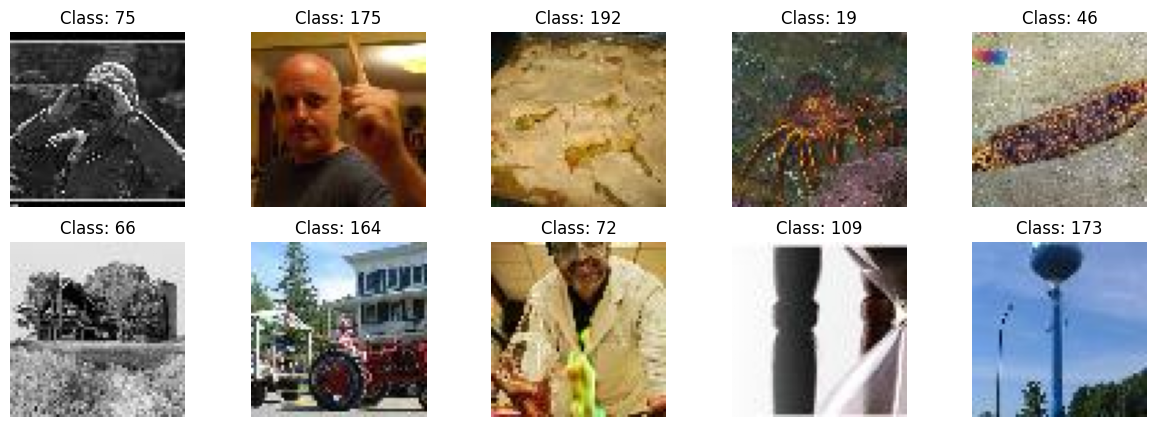

In [ ]:
for batch in train_dataloader:
    images, labels = batch
    break

fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i in range(2):
  for j in range(int(5)):
    index = i*int(5) + j

    # img = images[index].permute(1, 2, 0).numpy()  # (3, 64, 64) -> (64, 64, 3)
    img = rearrange(images[index], "C H W -> H W C").numpy()  # (3, 64, 64) -> (64, 64, 3)
    label = labels[index]

    axs[i][j].imshow(img)
    axs[i][j].set_title(f"Class: {label}")
    axs[i][j].axis("off")

plt.show()

# 📺 Diffusion Models



Diffusion models are based on a forward process and a backward process.

1.   In the **forward process**, noise is added to the input data in incremental way, i.e. using
steps of normal distributed noise. The forward process is usually denoted with the letter $q$.

2.   In the **backward process**, a trained neural network is used to predict the mean and variance of the noise which allows us to reverse the added noise, i.e. backing up to the previous step in diffusion path. The backward process is usually denoted with the letter $p_{\theta}$ where the subscript $\theta$ indicates that it is a learnable process.

In the original diffusion model presented by [Ho et al., (2020)](https://arxiv.org/abs/2006.11239) the authors decided to use only the mean as the learnable parameter and keep the variance fixed through a variance schedule.

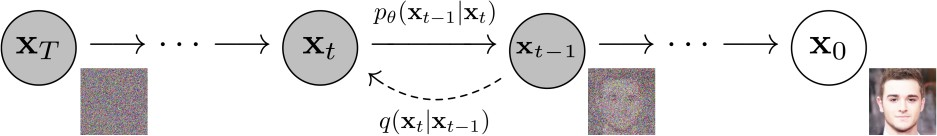

## Variance scheduler
The variance scheduler is as simple as it's called: it defines (schedule! 😀) the variance at each given timestep during the Markov chain, from $t=0$ to $t=T$ (i.e. the maximum timestep). In particular, at each step, Gaussian noise $\epsilon$ is added to the previous image, as defined by the formula

$$x_{t+1}=\sqrt{1-\beta}\;x_t + \sqrt{\beta_t}\;\epsilon$$

A well behaved variance scheduler is **important to ensure the quality of the trained model**; this is because the amount of noise added depends on the variance chosen through the schedule process.

We'll see two variance scheduler, that comes from the principal papers about diffusion models:

*   **Linear**, introduced in [Ho et al., (2020)](https://arxiv.org/abs/2006.11239), that achieve considerable results.

*   **Cosine-based**, defined in [Nichol and Dhariwal, 2021](https://arxiv.org/abs/2102.09672), that unlike the linear one, is meant to low resolution images.

THe following is the comparison between the linear (above) and cosine (below) variance scheduler

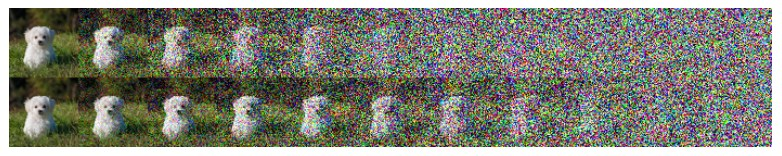

as you can see, the upper sequence of images (linear schedule) becomes noisier early on in the forward noising process, which leads to a lower sample quality and suboptimal training as timesteps increase. Cosine schedule ensure that the sample quality remains consistent.



In this project we'll use the Cosine-based scheduler, that is mainly based on the following formula

$$\bar{\alpha}_t=\dfrac{f(t)}{f(0)}\qquad f(t)=\cos\left(\dfrac{\frac{t}{T}+s}{1+s}*\frac{pi}{2}\right)^2$$

and so, we can compute variance values using $\bar{\alpha}_t$ as follows

$$\beta_t=1-\dfrac{\bar{\alpha}_t}{\bar{\alpha}_t-1}$$

in this way it avoids too little noise in the beginning and too much noise at the end, allowing considerable increase in the noise in the middle.\
This ensures that **samples at any timestep are equally valuable** to the training process

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

## Forward/Backward diffusion process

To make things compact, I've re-created a class that handles the diffusion process. This is an adpatation from the one proposed by DDPM.

Methods are commented before the definition in order to understand their general behavior and when needed I've added some comments to explain the ambiguous lines of code.

In [ ]:
class Diffusion():
    def __init__(self,
                 model,
                 image_resolution=[config.image_channels, config.image_size, config.image_size],
                 n_times=config.diffusion_timesteps,
                 device=device):

        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_C, self.img_H, self.img_W = image_resolution

        self.model = model

        # define cosine variance schedule (betas)
        betas = cosine_beta_schedule(timesteps=n_times).to(config.device)
        self.sqrt_betas = torch.sqrt(betas)

        # define alphas for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-self.alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)

        self.device = device

    def extract(self, a, t, x_shape):
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))

    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be very important
        # to train reverse process network
        return x * 2 - 1

    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5


    # perturbs the input x_zeros to generate a noisy sample x_t.
    def make_noisy(self, x_zeros, t):
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)

        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)

        # Let's make noisy sample! (i.e. forward process)
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar

        return noisy_sample.detach(), epsilon


    # perturbs the input image and predicts the noise added at each timestep
    def perturb_and_predict(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)

        B, _, _, _ = x_zeros.shape

        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)

        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)

        return perturbed_images, epsilon, pred_epsilon


    # denoises the image at timestep t to get the image at the previous timestep t-1.
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)

        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)

        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z

        return x_t_minus_1.clamp(-1., 1)

    # generates samples starting from random noise
    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)

        # denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)

        # rescale x_0 into [0, 1] ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0

### Forward diffusion test on sample image

In [ ]:
def test_forward_process():
    from PIL import Image
    import requests

    url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    img = Image.open(requests.get(url, stream=True).raw)
    tensor_img = transforms.ToTensor()(img).to(config.device)
    def get_noisy_image(x_start, t):
        # add noise
        x_noisy = q_sample(x_start, t=t)

        # turn back into PIL image
        reverse_transform = transforms.Compose([
            transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
            transforms.Lambda(lambda t: t * 255.0),
            transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
            transforms.ToPILImage(),
        ])
        noisy_image = reverse_transform(x_noisy.squeeze())

        return noisy_image

    t = torch.tensor([1], device=config.device)

    def plot(imgs):
        fig, axs = plt.subplots(1, len(imgs), figsize=(15, 5), squeeze=False)

        for i, img in enumerate(imgs):
            ax = axs[0, i]
            ax.imshow(np.asarray(img))
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

        plt.tight_layout()

    plot([get_noisy_image(tensor_img, torch.tensor([t], device=config.device)) for t in [0,1,2,5,10,15]])
test_forward_process()

# ⚡ Original architecture implementation via Lightning

In [ ]:
# total amount of resolutions
number_of_resolutions = config.resolutions
# input per-level resolutions
resolutions = [config.image_size//2**i for i in range(number_of_resolutions)]
# the number of residual blocks per resolution level
per_level_residual_blocks = config.per_level_residual_blocks
# blocks that has a skip connection
residual_connection_level = (False, False, True, False, True, False) # F, F, T, F, T, F
# base channel dimension
base_dim = config.base_channels_dim
# initial image shape
image_shape = [config.image_channels, config.image_size, config.image_size]

In [ ]:
# creating the model
model = DiffiT(image_shape, base_dim, resolutions, number_of_resolutions, per_level_residual_blocks, residual_connection_level).to(device)

In [ ]:
# instantiating forward/backward diffusion class handler
diffusion = Diffusion(model, image_resolution=image_shape, device=device)

## Helper functions

In [ ]:
def draw_sample_image(x, title):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(title))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [ ]:
def draw_sample_perturbed_images():
    model.eval()
    for batch_idx, (x, _) in enumerate(test_dataloader):
        x = x.to(device)
        tmp = diffusion.scale_to_minus_one_to_one(x)
        perturbed_images, epsilon, pred_epsilon = diffusion.perturb_and_predict(x)
        perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)

        if debug:
            print(np.max(np.asarray(x.cpu())), np.min(np.asarray(x.cpu())))
            print(np.max(np.asarray(tmp.cpu())), np.min(np.asarray(tmp.cpu())))
            print(np.max(np.asarray(perturbed_images.cpu())), np.min(np.asarray(perturbed_images.cpu())))
        break
    draw_sample_image(perturbed_images, "Perturbed Images")
# draw_sample_perturbed_images()

In [ ]:
def draw_architecture():
    import torchvision
    from torchview import draw_graph
    import graphviz

    graphviz.set_jupyter_format('png')

    model_graph = draw_graph(model, input_size=((16,3,64,64), (16, 1)), expand_nested=True, depth=1)
    return model_graph.visual_graph
# draw_architecture()

## Pytorch Lightning

<h2>Loss function</h2>

Since the underlying architecture is the one of diffusion models, these can be written as learning the following **denoising autoencoder objective**

$$
    \mathbb{E}_{q_0(x_0),\; p(t)\sim t,\; \varepsilon\sim \mathcal{N}(0, I)}\left[\lambda(t)||\varepsilon - \varepsilon_{\theta}(z_0+\sigma_t\varepsilon,\;t)||^2_2\right]
$$

Intuitively, given a noisy sample from $q(z_t)$ (generated via $z_t=z_0+\sigma_t\varepsilon$), a neural network $\varepsilon_{\theta}$ is trained to predict the amount of noise added (i.e. $\varepsilon$).

The just mentioned objective (implemented with an MSE loss function) is also known as **denoising score matching**, where the goal is to try to fit the data score with a neural network, also known as the score network.




In [ ]:
class LitDiffiT(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, _ = batch
        _, epsilon, pred_epsilon = diffusion.perturb_and_predict(x)

        # loss function
        loss = F.smooth_l1_loss(epsilon, pred_epsilon)

        # display and deliver logs
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        _, epsilon, pred_epsilon = diffusion.perturb_and_predict(x)

        # loss function
        loss = F.smooth_l1_loss(epsilon, pred_epsilon)

        # log to TensorBoard
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, _ = batch
        _, epsilon, pred_epsilon = diffusion.perturb_and_predict(x)

        # loss function
        loss = F.smooth_l1_loss(epsilon, pred_epsilon)

        # log to TensorBoard
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=config.learning_rate)
        return optimizer

In [ ]:
# defining the model
diffit = LitDiffiT(model)

## Loggers

In [ ]:
def select_logger(logs_name, selected="csv"):
    if selected == "wandb":
        import wandb
        from lightning.pytorch.loggers import WandbLogger
        wandb.login(key="6d550e12a1b8f716ebe580082f495c01ed2adf6c") # 6d550e12a1b8f716ebe580082f495c01ed2adf6c
        logger = WandbLogger(log_model="all")
        wandb.init(project="diffit")

    elif selected == "tensorboard":
        from lightning.pytorch.loggers import TensorBoardLogger
        logger = TensorBoardLogger("training_logs", name=logs_name)

    elif selected == "csv":
        from lightning.pytorch.loggers import CSVLogger
        logger = CSVLogger("training_logs", name=logs_name)

    else:
        logger = None

    return logger

logger = select_logger("diffit_lr=1e-3_e=10_b=64", None)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath=default_dir + config.checkpoint_dir_name,
    filename='{epoch}-{step}-{train_loss:.4f}-{val_loss:.4f}',
    save_last=True,
    enable_version_counter=True
)

## Training

In [ ]:
# let's train DiffiT
trainer = L.Trainer(
    max_epochs=10,
    default_root_dir=default_dir + config.checkpoint_dir_name,
    callbacks=[checkpoint_callback, ModelSummary()],
    enable_checkpointing=True,
    logger=logger,
    accelerator="auto",
)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [ ]:
resume = False
if resume:
    path = default_dir + config.checkpoint_dir_name + '/last.ckpt'

    trainer.fit(
        model=diffit,
        ckpt_path=path,
        train_dataloaders=train_dataloader,
        val_dataloaders=valid_dataloader
    )
else:
    trainer.fit(
        model=diffit,
        train_dataloaders=train_dataloader,
        val_dataloaders=valid_dataloader
    )

2024-05-31 14:12:37.146232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 14:12:37.146327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 14:12:37.275151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working/checkpoint exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type   | Params
---------------------------------
0 | model | DiffiT | 74.9 M
---------------------------------
74.9 M    Trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


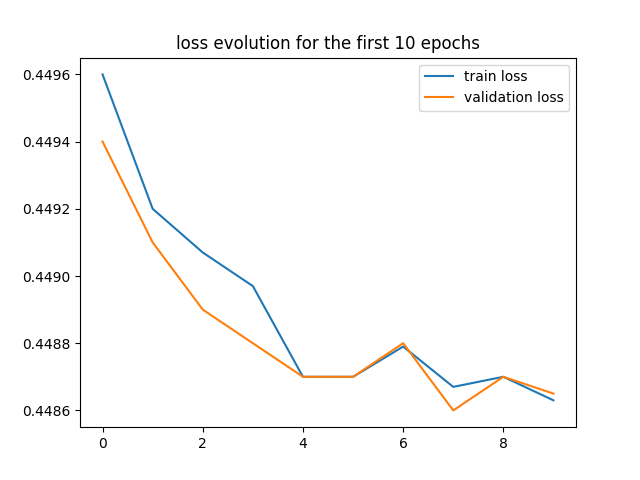

In [ ]:
trainer.test(diffit, dataloaders=test_dataloader)

In [ ]:
evaluation = True
if evaluation:
    checkpoint = "last.ckpt"
    diffit = LitDiffiT.load_from_checkpoint(checkpoint, model=model)

# 💯 Sampling (inference)

In [ ]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=64)

In [ ]:
draw_sample_image(generated_images, "Generated Images")

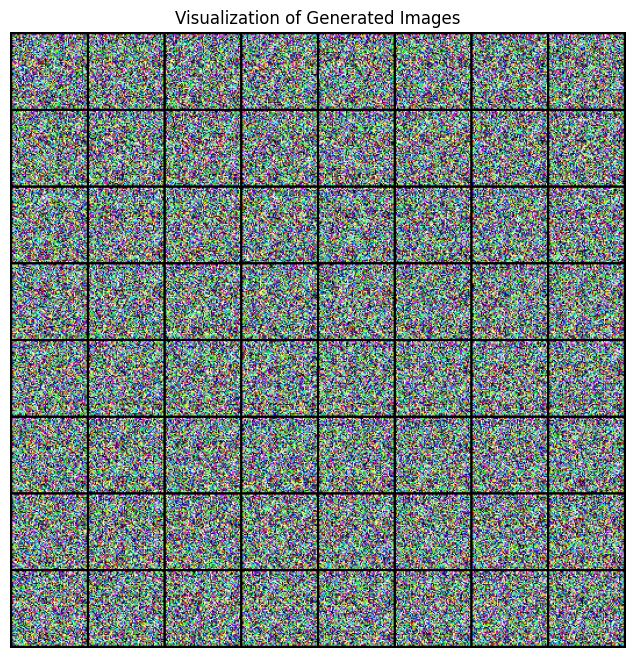

# 💬 Comments on the original implementation

<h2>💯 Original architecture problem</h2>

As we could expect, the training time of such models is really high. Ehile we analyze the computational complexity of a model, there are various components that increase the computational burden. Implementing the original network architecture, will lead to the following statistics

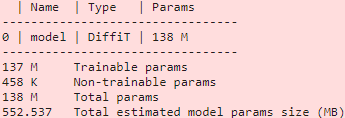

and to a computational time for a single epoch equals to

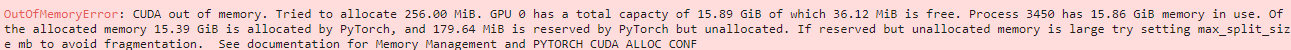

exactly; I couldn't manage to execute the original network since it requires too much memory to fit inside the gpu's memory.

<h2>🔽 Scaled architecture</h2>
In order to deal with such problem, I had to downscale parameters (see next section: "Semplifications"). Anyway, the hardest hyperparameters that there are inside DiffiT network are the number of Residual layers in series for each resolution level (in the paper they refer to them as $L_1, L_2, L_3, L_4$). So first of all i tried to scale them, and finally I've obtained the amount of time needed to train such scaled architecture.

The model has the following statistics

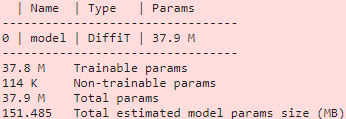

and to train a single epoch of such a model, are required more than 10 hours:

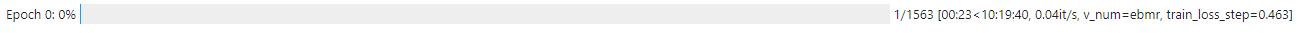

<h2>⏬ Super-scaled architecture </h2>

In order to obtain a reasonable training time, I've have to do a bunch of further semplifications (see next section: "Semplifications"); obtaining the following architecture statistics

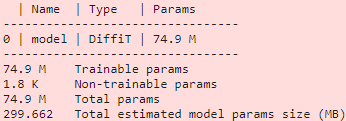


and the following training time for a single epoch os such super-scaled architecture

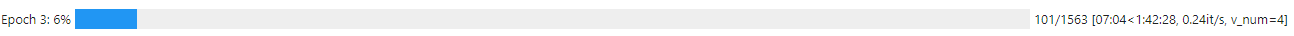


Just for fun, I tried to train this super scaled architecture using the Google Colab CPU; it seems to require more than 117 hours to train a single epoch!

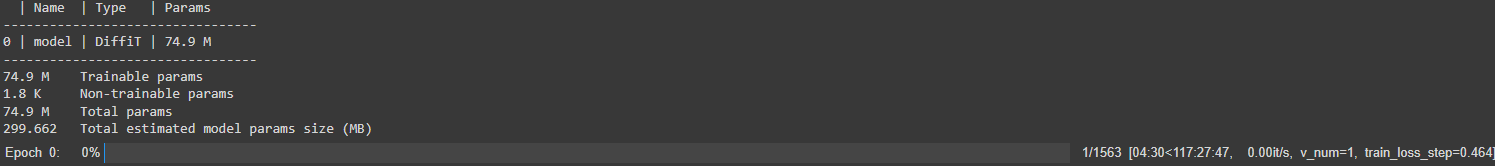

<h2>🧰 Training tools</h2>

The training of the above implemented networks has been done using Kaggle Notebooks environment, with a weekly time-limited GPU (P100) usage of 12 hours (but you can't stay away from your PC from more than 30 minutes, otherwise it'll interrupt the session).

The reason why for training the model I didn't use Google Colab is that with its own T4 GPU it takes more than 2.5 hours to compute a single epoch of the super-scaled architecture. So I decided to switch to Kaggle.

However, with Kaggle the time I've **saved** is **no more than 30 minutes**.

<h2>😞 Semplifications</h2>

in order to obtain these "only" 2 hours to train the model for a single epoch, I had to ***decrease*** the general complexity of the model. In particular, the things I've modified are the following:<p> $\\[0.3cm]$ </p>

* The **number of patches** per side, from 8 to 2; i.e. using a 64x64 image, instead of obtain a total of 64 (8 per side) patches of size 8x8, now I obtain 4 (2 per side) patches of size 32x32. A training loop with 8 patches per side will approximately triple the training time.\
  Has been shown in [Scalable Diffusion Models with Transformers, 2023, figure 7](https://arxiv.org/pdf/2212.09748.pdf), that to achieve better results we need greater transformer sizes and smaller patch sizes.\
  We can obtain a more complex architecture by just increasing `patches_number` in the configuration object.<p> $\\[0.3cm]$ </p>
  
* The **number of DiT** (Diffusion Transformer) blocks in series per ViT (Vision Transformer) module is 1 instead of 2.\
  An architecture with 2 DiT in series it's depicted in [U-DiT TTS: U-Diffusion Vision Transformer for Text-to-Speech, 2023, figure 1](https://arxiv.org/pdf/2305.13195.pdf).\
  We can obtain a more complex architecture by just increasing `num_transformer_blocks` in the configuration object.<p> $\\[0.3cm]$ </p>
  
* The **number of residual blocks** (ResBlock) per resolution level is 1 instead of 4; in particular in the paper ([DiffiT: Diffusion Vision Transformers for Image Generation](https://arxiv.org/pdf/2312.02139)) there is an hyperparameter $L_i$ that helps in defining how many Residual blocks are in series for the $i$-th resolution layer of our model.
  Authors used $L_1=L_2=L_3=L_4=4$ while in my case, I've used $L_1=L_2=L_3=L_4=1$.\
  We can obtain a more complex architecture by just increasing `per_level_residual_blocks` in the configuration object.<p> $\\[0.3cm]$ </p>

* The **hidden state dimensionality of the transformer model** is 64 instead of 256. Authors shown that increase too much this dimensionality won't lead to better performance; indeed increasing token's dimensionality (for both time and feature) lead to worse performances (see Table 3 of [DiffiT: Diffusion Vision Transformers for Image Generation](https://arxiv.org/pdf/2312.02139)).\
  We can obtain a more complex architecture by just increasing `hidden_dimension` in the configuration object.<p> $\\[0.3cm]$ </p>

* The **time MLP ratio** is 2 instead of 4. This is a multiplier that increase the initial time embedding dimension. Since we are using a few amount of diffusion timesteps, its scaling is not really a bad thing: I am saving a bunch of not-really-necessary memory.\
  We can obtain a more complex architecture by just increasing `time_mlp_ratio` in the configuration object.<p> $\\[0.3cm]$ </p>





<h2>💣 Author's training setup</h2>

The original architecture **has been trained for 200.000 epochs** using **8 NVIDIA A100 GPUs** (just to do a comparison, each GPU costs oscillates between around 20.000€ and 40.000€, depending on the website and on the memory size, i.e. 40/80 GB), and this is due to various components:

* **Transformer** architecture in general are **not easy to train**, since the self-attention mechanism has a cost quadratic in the input
* **Diffusion models**, requires to train for each timestep, so the network needs to learn how to remove noise at each step; moreover, this paper introduce also learnable diffiusion time embedding, that increase the burden on the computational complexity.
* we are **dealing with images**, also if without relatively low resolution
* also if the **forward process** it's not a netural network, it needs its time to apply noise over an image
* in general **U-Net-like architectures** are slow in learning, especially if they have lots of resolution layers

Anyway, their results are really awsome: follows some results from the paper

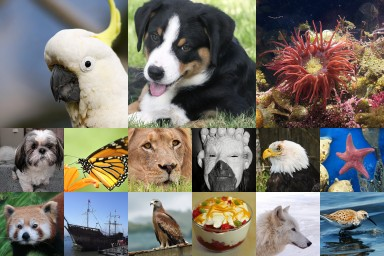



while on FFHQ-64 they got the following images

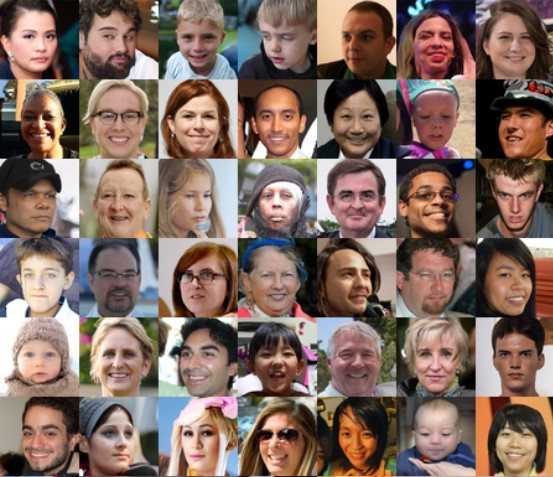

<h2>⭐ Paper's results</h2>
Authors achieved the State Of The Art (SOTA) with the following FID scores agains two low resolution datasets: FFHQ ($64\times64$) and CIFAR-10 ($32\times32$)


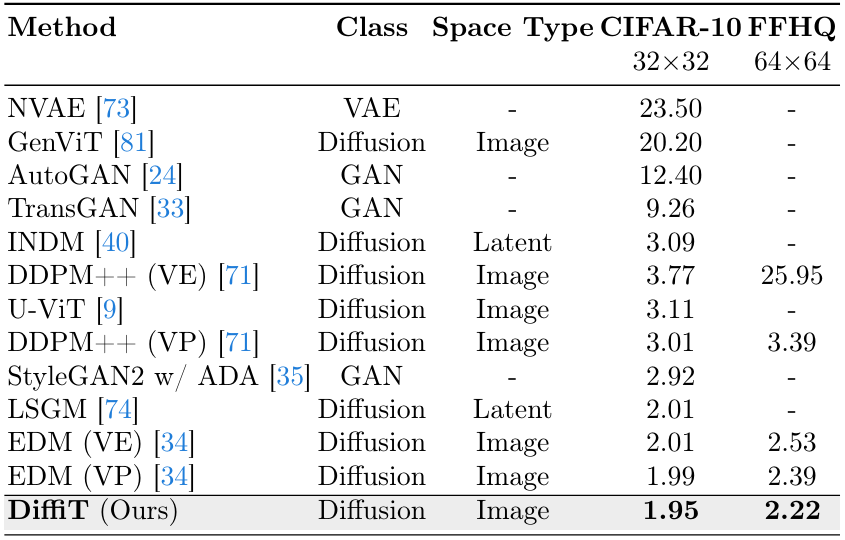


For datasets with higher resolution images (like ImageNet-256/512), the authors proposed the Latent DiffiT model, that achieves a SOTA FID score of 1.73!

So, to be as complete as possible, the changes that I need to do in order to reproduce as most as possible the original architecture are the following (or in general, we could do "*run all*" with the flag `hard_mode=True`; you can find it at the start of the notebook)

In [ ]:
# authors does not explicitly mention their path size, or the number of patches
# per image, but these are reasonalble numbers in thiw way, we split each
# 64x64 channel in 8x8
# UNCOMMENT -> config.patches_number = 8

# also here, authors does not explicitly mention the number of consecutive
# diffusion transformers blocks (DiT) per residual level, but seeing other
# architectures, 2 is a common number
# UNCOMMENT -> config.num_transformer_blocks = 2

# in this way we are using 4 residual layers per resolution level (as in paper)
# UNCOMMENT -> config.per_level_residual_blocks = (4, 4, 4, 4)

# in this way we are changing hidden dimension from 64 to 256
# UNCOMMENT -> config.hidden_dimension = 256

# in this way we are changing time sequential model dimension multiplier from 2 to 4
# UNCOMMENT -> config.time_mlp_ratio = 4

# 🔲 Grayscale variant

**Initially** I tought that a grayscale approach would be better in terms of computational complexity. But since **the number of channel transformations are fixed given an input**, the resulting training time it's literally the same.

In order to show how simple is the training process setup, the following is the grayscale variant training (without the trainer).

In [ ]:
config.image_channels = 1

image_shape = [config.image_channels, config.image_size, config.image_size]

## Data loading

In [ ]:
# transformation to be applied
transform = transforms.Compose([
    # to NumPy array, H*W*C dimensions, and divide by 255
    transforms.ToTensor(),
    # apply grayscale
    transforms.Grayscale()
])

# path to dataset
train_dataset_path = default_dir + "tiny-imagenet-200/tiny-imagenet-200/train"
test_dataset_path = default_dir + "tiny-imagenet-200/tiny-imagenet-200/test"
valid_dataset_path = default_dir + "tiny-imagenet-200/tiny-imagenet-200/val"

# loading dataset
train_dataset = ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform)
valid_dataset = ImageFolder(root=valid_dataset_path, transform=transform)

# dataLoader for dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=config.workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=config.workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=config.workers)

## Training

In [ ]:
model_grayscale = DiffiT(image_shape, base_dim, resolutions, number_of_resolutions, per_level_residual_blocks, residual_connection_level).to(device)

In [ ]:
# instantiating forward/backward diffusion class handler
diffusion = Diffusion(model_grayscale, image_resolution=image_shape, device=device)

In [ ]:
# defining the model
diffit_grayscale = LitDiffiT(model_grayscale)

In [ ]:
trainer = L.Trainer(
    max_epochs=10,
    default_root_dir=default_dir + config.checkpoint_dir_name,
    callbacks=[checkpoint_callback, ModelSummary()],
    enable_checkpointing=True,
    logger=logger,
    accelerator="auto",
)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model=diffit,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
2024-05-31 13:57:56.175291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 13:57:56.175453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 13:57:56.304542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#🔎 Optimize DiffiT (*Efficiency Is All You Need*)

There are a plenty of way to optimize DiffiT:
1. **Decrease** the number of **MACs**, **FLOPs** and the **memory footprint**
2. **Quantization**, so to reduce the precision of the weights, biases, and activations such that they consume less memory
2. Use (also if slightly utilized) **compact design CNN**
3. MetaFormer and in particular **PoolFormer**, that **replace Attention layer with a Pooling Layer**, that helps to decrease the MACs and FLOPs thanks to substituting the attention layer with a quadratic (i.e. $O(n^2)$) cost with a constant operation; maintaining good performances as shown in [MetaFormer Is Actually What You Need for Vision, 2022](https://arxiv.org/abs/2111.11418).

Note that also if not mentioned, there are other ways to optimize this a network (e.g. **Mixed Precision Procedure**) but will not taken into account.

Now let's have a bunch of background, while checking everything just said, and next trying to upgrade the network.


First of all, we need to count initial model parameters, so to do a comparison:

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

diffit_params = count_parameters(model)
grayscale_params = count_parameters(model_grayscale)

print(f"RGB model's parameters: {diffit_params}")
print(f"Grayscale model's parameters: {grayscale_params}")

RGB model's parameters: 74913667
Grayscale model's parameters: 74909057


note that as we said, the two models are really similar in terms of parameters; in fact in the grayscale model we have just

$$74.913.667 - 74.909.057 = 4610$$

parameters less than the RGB one; and this is obvious, since the dependency on the image channels relies only on the first and the last layers, i.e. the Tokenizer and the Head; that have the job to take the channels of the latent image back to its original size.



In [ ]:
rgb_image = torch.randn(16, 3, 64, 64)
grayscale_image = torch.randn(16, 1, 64, 64)
time = torch.randn(16, 1)

## **MACs** *(i.e Multiply and Accumulate opertions*)





are a unit of measurement used to evaluate the computational workload of a neural network during training and inference. It **represent the number of multiplications AND additions performed** to compute the output of a single neuron/layer/model in the neural network structure. For example, let $a$, $b$, and $c$ floating point numbers, one single MAC will be represented by the following update
$$
a\leftarrow a+(b\times c)
$$
Is an important **indicator of the computational complexity of the model** and can be used to compare different neural network architectures in terms of computational efficiency.


In [ ]:
from thop import profile
diffit_macs, diffit_params = profile(model, inputs=[rgb_image, time], verbose=False)
grayscale_macs, grayscale_params = profile(model_grayscale, inputs=[grayscale_image, time], verbose=False)

print(f"RGB model's MACs:{diffit_macs}")
print(f"Grayscale model's MACs:{grayscale_macs}")

RGB model's MACs:166671761408.0
Grayscale model's MACs:166369771520.0


## **FLOPs** *(i.e. Floating Point Operations)*



refers to the total number of any mathematical operation involving floating point numbers by a neural network. They indicate the amount of work required for training or inference. They are 2 times the number of macs, since it adds and multiply.

In [ ]:
diffit_flops = (2*diffit_macs)/1e9
grayscale_flops = (2*grayscale_macs)/1e9

print(f"RGB model's FLOPs: {diffit_flops} billions")
print(f"Grayscale model's FLOPs: {grayscale_flops} billions")

RGB model's FLOPs: 333.343522816 billions
Grayscale model's FLOPs: 332.73954304 billions


## **Quantization**

Quantization is a technique to **reduce the computational and memory costs** of running inference by representing the weights and activations with low-precision data types like 16-bit floating point (`float16`) or 8-bit integer (`int8`) instead of the usual 32-bit floating point (`float32`).

<h3>How to quantize</h3>

The quantization from `float32` to `float16` is quite straightforward, both of them have the same numerical representation; while from `float32` to `int8`, is a bit more tricky: let's consider an floating point number $x$ that takes values in $[a, b]$, and a relative quantized 8-bit integer $x_q$. We can write the following quantization scheme (also called *affine quantization scheme*)
$$x = S*(x_q-Z)$$
with $S$ and $Z$ that are parameters of the quantization, such that $S$ is a positive float32; while $Z$, named also "*zero-point*", is the int8 value corresponding to the value 0 in the float32 realm. Then the quantized value $x_q$ in $[a, b]$ can be computed as follows:
$$x_q = round\left(Z + \frac{x}{S}\right)$$
And float32 values outside of the [a, b] range are clipped to the closest representable value, so for any floating-point number x:
$$x_q = clip\left(round\left(\frac{x}{S} + Z\right), round\left(\frac{a}{S} + Z\right), round\left(\frac{b}{S} + Z\right)\right)$$

<h3>Types of quantization</h3>

Note that there are **two main techniques to implement quantization**, and they differ mainly by the calibration mode (these methods needs to be calibrated using training data, it refers to the computation of `float32` ranges):
* **Dynamic** the weights' range for each activation is computed *on the fly at runtime* (i.e. during inference).
<p> $\\[0.2cm]$ </p>
* **Static** (Post Training Quantization) the weights' range for each activation is computed in advance at *quantization-time* (i.e. when the float32 ranges are computed). It fuses activations into preceding layers where possible.
<p> $\\[0.2cm]$ </p>

PyTorch provides quantization techniques in the library `torch.quantization`.

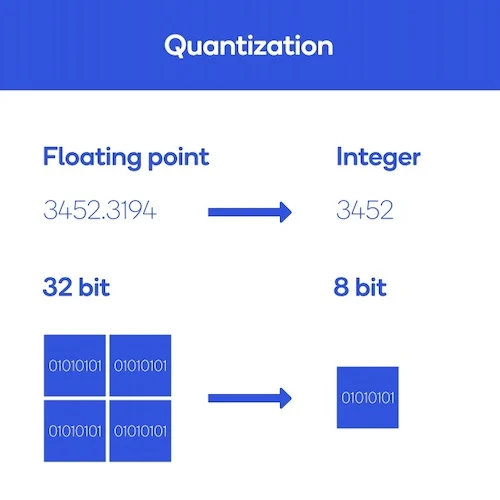

In [ ]:
def quantize_model():
    model = DiffiT(image_shape, base_dim, resolutions, number_of_resolutions, per_level_residual_blocks, residual_connection_level).to(device)
    model.eval()

    # select the observer to attach: server inference
    model.qconfig = torch.ao.quantization.get_default_qconfig('x86')

    # static quantization tries (where possible) to fuse layers
    model_fused = torch.ao.quantization.fuse_modules(model, [['conv', 'relu']])

    # insert observers in the model that will observe activation tensors during calibration
    model_prepared = torch.ao.quantization.prepare(model_fused)

    # reload last checkpoint
    diffit = LitDiffiT.load_from_checkpoint("last.ckpt", model=model_prepared)

    # calibrate quantizer with test data
    trainer.test(diffit, dataloaders=test_dataloader)
    # evaluate(model_prepared, criterion, data_loader, neval_batches=num_calibration_batches)

    # convert model to its quantized version
    model_int8 = torch.ao.quantization.convert(model_prepared)

    # test the quantized model
    res = model_int8(input_data)
# model_int8 = quantize_model()

## **Memory footprint**

The memory footprint of a neural network is the amount of memory needed to store all the parameters of the model.

In [ ]:
def get_model_memory_usage(model, image, time):
    params = count_parameters(model)

    activations = model(image, time)
    activations_memory = activations.element_size() * activations.nelement()

    total_memory = activations_memory + params * 4 # assuming 4 bytes per parameter
    return total_memory / (1024 ** 2) # Megabytes

diffit_memory_usage = get_model_memory_usage(model, rgb_image, time)
grayscale_memory_usage = get_model_memory_usage(model_grayscale, grayscale_image, time)

print("RGB model's memory footprint:", diffit_memory_usage, "MB")
print("Grayscale model's memory footprint:", grayscale_memory_usage, "MB")

RGB model's memory footprint: 286.5229606628418 MB
Grayscale model's memory footprint: 286.00537490844727 MB


## EER *(Efficient Error Rate)* -> [Paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10508091)

Directly from some PhD students (Papa, L. and Russo, P.) and a professor of our department (Amerini, I.) there is an error metric to compare two models i.e. a reference ($R$) model w.r.t. an analyzed model ($M$) against a set of efficiency metrics ($i$); it is computable easily as follows:

$$EER=\frac{1}{||i||}\sum_i\left(\frac{M_i}{R_i}\right)\qquad i\in \{\#\text{Parameters}, \text{FLOPs}, \text{MACs}, \dots\}$$

In [ ]:
def compute_EER(metrics_analyzed_model, metrics_reference_model):
    return 1/len(metrics_reference_model) * sum(np.divide(metrics_analyzed_model, metrics_reference_model))

metrics_reference_model = [diffit_memory_usage, diffit_flops, diffit_params, diffit_macs]
metrics_analyzed_model = [grayscale_memory_usage, grayscale_flops, grayscale_params, grayscale_macs]

ratio = compute_EER(metrics_analyzed_model, metrics_reference_model)

print("The EER of DiffiT with respect to it's grayscale counterpart is", ratio)

The EER of DiffiT with respect to it's grayscale counterpart is 0.9986270367126172


## Compact design CNN *(Depthwise Separable Convolution)*

Also with the introduction of Attention layers in Transformers, Convolutional layers are still quite used since they are really good when we deal with spatial information and locality. A few Years ago, Google with [MobileNets, 2017](https://arxiv.org/abs/1704.04861) introduced the *Depthwise Separable Convolution* (then used also in [Xception, 2017](https://arxiv.org/abs/1610.02357), still Google) that are characterizez by:
* **Depthwise Convolution**: Each input channel is convolved separately with its own set of filters (i.e. convolution is applied to a single channel at a time).
* **Pointwise Convolution**: The output channels, from the depthwise convolution, are combined through a 1x1 convolution.

### **Example**

Let's make an example to clear doubts: suppose there is ann input data of size $H_I\times W_I\times C_I=64\times64\times3$ (i.e. our case); our initial block of the model has $N=128$ filters of size $H_k\times W_k\times C_k=3\times3\times3$, so we end up to an "image" of size $H_I'\times W_I'\times N=31\times31\times128$ and the total number of multiplications done in a classic Conovlutional layer are is
$$\begin{align}
N \times (H_I' \times W_I') \times (H_k\times W_k \times C_k) &= 128\times (31\times31)\times (3 \times 3\times3) \\
&= 3.321.216 \quad \text{operations}
\end{align}$$
for the Depthwise Separable Convolution the amount of total operations are

* in **depthwise convolution** we have $C_I=3$ kernels of size $H_k\times W_k\times \bar{C_k} = 3\times3\times1$ that moves $H_I' \times W_I' = 31\times31$ times, that gives the following amount of operations
$$3\times 3\times 3\times 31 \times 31 = 25.947$$

* in **pointwise convolution** we have $N=128$ filters of size $1\times1\times C_k = 1\times1\times 3$ that moves $H_I' \times W_I' = 31\times31$ times, that gives the following amount of operations
$$128\times1\times1\times3\times31\times31=369.024$$
for a total amount of operations that is
$$\begin{align}
C_k \times H_I'\times W_I' \times (H_k\times W_k + N) &= 3\times 31^2\times(3^2 + 128)\\
&= \text{depthwise convolution operations } + \text{ pointwise convolution operations}\\
&= 394.971\quad\text{operations}
\end{align}$$

in order to be as formal as possible, to compare them we need to compute the following ratio
$$R = \dfrac{\text{Complexity of depth wise separable convolutions }}{\text{Complexity of standard convolution}} = \dfrac{394.971}{3.321.216}=0,1189$$
this means that the depth wise separable convolution network, in this example, performs **$\sim$10 times less operations** as compared to a standard constitutional neural network. Can be shown that in examples with higher dimensional input images, this ratio will decrease (leading to an higher increase in performances).

Moreover, since Depthwise Separable convolutions uses less parameters, they are good in **reducing overfitting**. Here is a graphical interpretation

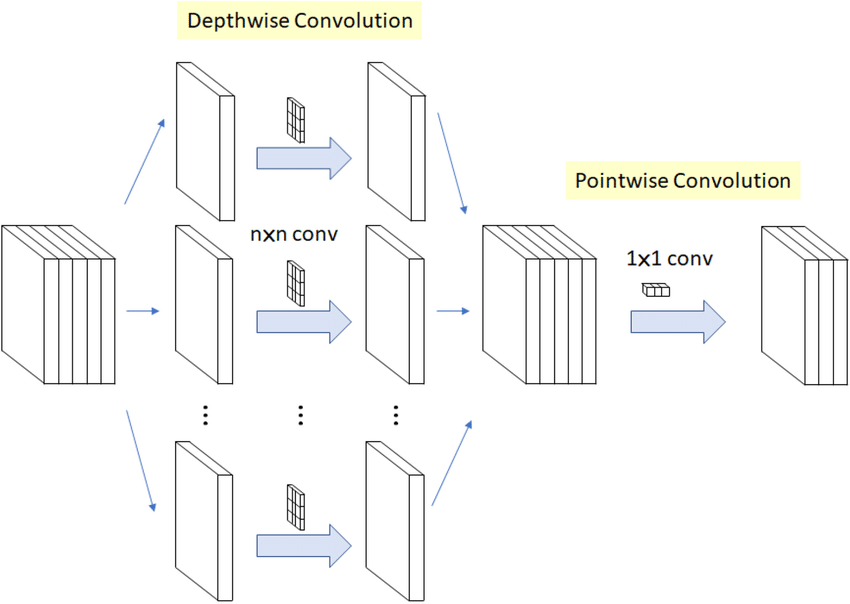

In [ ]:
class DepthwiseSeparableConv2D(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size=3, stride=2, padding=1):
        super(DepthwiseSeparableConv2D, self).__init__()
        # "groups=dim_in" is needed in order to convolve each input channel with its own set of filters
        self.depthwise_convolution = nn.Conv2d(dim_in, dim_in, kernel_size=kernel_size, padding=padding, stride=stride, groups=dim_in)
        self.pointwise_convolution = nn.Conv2d(dim_in, dim_out, kernel_size=1)

    def forward(self, x, t=None):
        x = self.depthwise_convolution(x)
        x = self.pointwise_convolution(x)
        return x

class DepthwiseSeparableConvTranspose2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size=4, stride=2, padding=1, output_padding=0):
        super(DepthwiseSeparableConvTranspose2d, self).__init__()
        self.depthwise_conv = nn.ConvTranspose2d(dim_in, dim_in, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, groups=dim_in, bias=False)
        self.pointwise_conv = nn.ConvTranspose2d(dim_in, dim_out, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x, t=None):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x

In [ ]:
def test_new_convs():
    dsc = DepthwiseSeparableConv2D(3, 128)
    dsct = DepthwiseSeparableConvTranspose2d(128, 3)

    res = torch.randn(1, 3, 64, 64)

    print("Initial size", res.size())
    res = dsc(res)
    print("Middle size", res.size())
    res = dsct(res)
    print("Final size", res.size())

test_new_convs()

Initial size torch.Size([1, 3, 64, 64])
Middle size torch.Size([1, 128, 32, 32])
Final size torch.Size([1, 3, 64, 64])


## MetaFormer (PoolFormer) and DiffiP (Diffusion Vision PoolFormer)

So, as described in [MetaFormer Is Actually What You Need for Vision, 2021](https://arxiv.org/abs/2111.11418) the substitution of the Attention Layer with a pooling layer lead to good results and damps a lot the number of MACs.

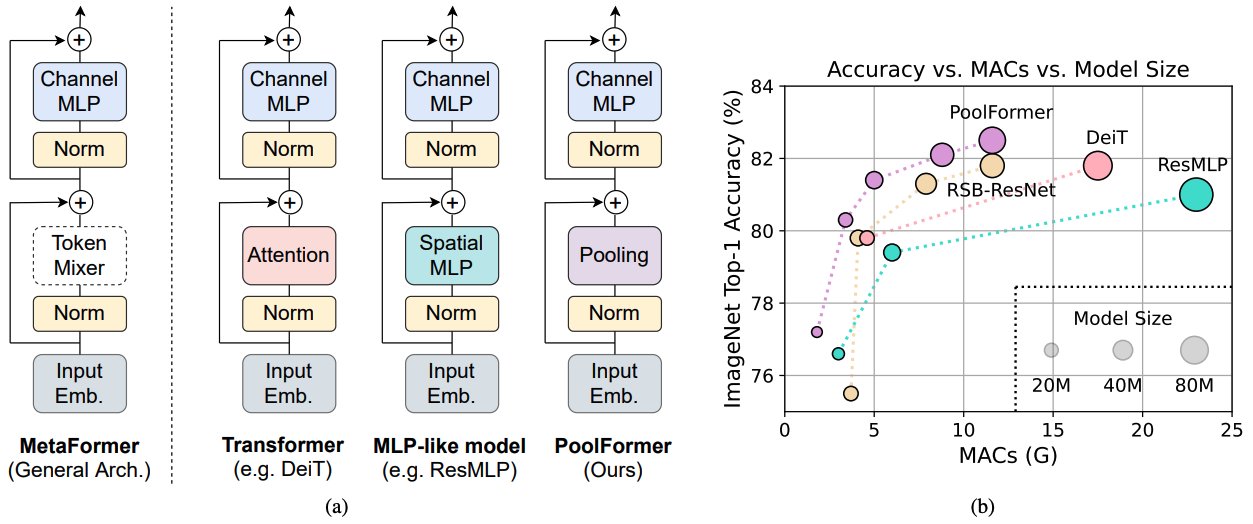

We will implements the PollFormer version of DiffiT (i.e. DiffiP, **Diffusion Vision PoolFormer**). If needed, [MetaFormer Baselines for Vision, 2022](https://arxiv.org/abs/2210.13452) introduce also some baselines to compare MetaFormers.\
Our architecture is the following:

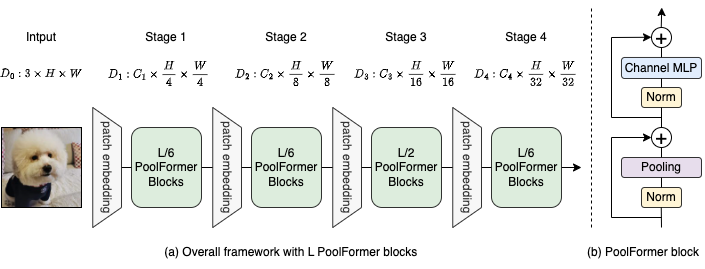

Note that in this case we are **completely changing the architecture**, since DiffiT was based on the new concept of Time-Dependent Self-Attention, while DiffiP does nothing like that (it actually does only an average pooling), but it's a good variant, and can be taken also as baseline. In particular, to implement it, we need to modify the class `VisionTransformerBlock` substituting the `TDMHSA` with an Average pooling layer

In [ ]:
# original implementation by Paper's author here: https://github.com/sail-sg/poolformer/blob/aa44f875bbcd975f455a597f4e46efe7fd94be3e/models/poolformer.py#L160
class Pooling(nn.Module):
    def __init__(self, pool_size=3):
        super(Pooling, self).__init__()
        self.pool = nn.AvgPool2d(
            kernel_size=pool_size,
            stride=1,
            padding=pool_size//2,
            # to avoid include zero padding in the computation
            count_include_pad=False
        )

    def forward(self, x):
        return self.pool(x)

class VisionPoolFormerBlock(nn.Module):
    # time_emb_dim and num_heads are useless
    def __init__(self, time_emb_dim, hidden_dim, num_heads, mlp_ratio):
        super(VisionPoolFormerBlock, self).__init__()

        # old tmsa - now pooling layer
        self.token_mixer = Pooling()

        # mlp
        self.mlp = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, mlp_ratio * hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_dim, hidden_dim)
        )

    def forward(self, x, t):
        out = self.token_mixer(x)

        out = out + self.mlp(out)
        return out

In [ ]:
def test_pooling():
    feature_dim = 128
    batch_size = 32

    data = torch.randn(batch_size, 4, feature_dim)

    p = Pooling()
    res = p(data)

    print(res.size())
test_pooling()

torch.Size([32, 4, 128])


In [ ]:
def test_poolformer():
    feature_dim = 128
    batch_size = 32

    vpf = VisionPoolFormerBlock(None, feature_dim, None, 4)

    patches = torch.randn(batch_size, 4, feature_dim)
    # time_emb = torch.randn(batch_size,  time_dim)

    res = vpf(patches, torch.randn(1, 1))

    print(res.size())
test_poolformer()

torch.Size([32, 4, 128])


# 💡 Lightweight variant

In [ ]:
config.image_channels = 3

image_shape = [config.image_channels, config.image_size, config.image_size]

In [ ]:
# transformation to be applied
transform = transforms.Compose([
    # to NumPy array, H*W*C dimensions, and divide by 255
    transforms.ToTensor(),
])

# path to dataset
train_dataset_path = default_dir + "tiny-imagenet-200/tiny-imagenet-200/train"
test_dataset_path = default_dir + "tiny-imagenet-200/tiny-imagenet-200/test"
valid_dataset_path = default_dir + "tiny-imagenet-200/tiny-imagenet-200/val"

# loading dataset
train_dataset = ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform)
valid_dataset = ImageFolder(root=valid_dataset_path, transform=transform)

# dataLoader for dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=config.workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=config.workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=config.workers)

In [ ]:
model_lw = DiffiT(image_shape, base_dim, resolutions, number_of_resolutions, per_level_residual_blocks, residual_connection_level,
                  vit_block_class=VisionPoolFormerBlock,
                  downsampling_class=DepthwiseSeparableConv2D,
                  upsampling_class=DepthwiseSeparableConvTranspose2d).to(device)

In [ ]:
# instantiating forward/backward diffusion class handler
diffusion = Diffusion(model_lw, image_resolution=image_shape, device=device)

In [ ]:
# defining the model
diffit_lw = LitDiffiT(model_lw)

In [ ]:
trainer = L.Trainer(
    max_epochs=10,
    default_root_dir=default_dir + config.checkpoint_dir_name,
    callbacks=[checkpoint_callback, ModelSummary()],
    enable_checkpointing=True,
    logger=logger,
    accelerator="auto",
)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model=diffit_lw,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
)

for the training time and parameters, see "Summary-Conclusion" section

In [ ]:
diffit_macs, diffit_params = profile(model, inputs=[rgb_image, time], verbose=False)
diffip_macs, diffip_params = profile(model_lw, inputs=[rgb_image, time], verbose=False)

# PARAMs
print(f"DiffiT model's parameters: {diffit_params}")
print(f"DiffiP model's parameters: {diffip_params}\n")

# MACs
print(f"DiffiT model's MACs: {diffit_macs}")
print(f"DiffiP model's MACs: {diffip_macs}\n")

# FLOPs
diffit_flops = (2*diffit_macs)/1e9
diffip_flops = (2*diffip_macs)/1e9

print(f"DiffiT model's FLOPs: {diffit_flops} billions")
print(f"DiffiP model's FLOPs: {diffip_flops} billions\n")

# FOORPRINT
diffit_memory_usage = get_model_memory_usage(model, rgb_image, time)
diffip_memory_usage = get_model_memory_usage(model_lw, rgb_image, time)

print("DiffiT model's memory footprint:", diffit_memory_usage, "MB")
print("DiffiP model's memory footprint:", diffip_memory_usage, "MB\n")

# EER
metrics_reference_model = [diffit_memory_usage, diffit_flops, diffit_params, diffit_macs]
metrics_analyzed_model = [diffip_memory_usage, diffip_flops, diffip_params, diffip_macs]
ratio = compute_EER(metrics_analyzed_model, metrics_reference_model)

print("The EER of DiffiT with respect to DiffiP is", ratio)

DiffiT model's parameters:74779395.0
DiffiP model's parameters:68188961.0

DiffiT model's MACs:166671761408.0
DiffiP model's MACs:21816471552.0

DiffiT model's FLOPs: 333.343522816 billions
DiffiP model's FLOPs: 43.632943104 billions

DiffiT model's memory footprint: 286.5229606628418 MB
DiffiP model's memory footprint: 260.94495010375977 MB

The EER of DiffiT with respect to DiffiP is 0.5210969006963715


# ⏫ Further upgrades and variants

There are a bunch of modifications that can be plugged over DiffiT network in order to create some variants and upgrade its performances (with the relative change in the amount of computational cost)

* **Different positional embeddings**: there are two other kinds of positional embeddings that could achieve good performances in this model:
  * **Rotary positional embeddings (RoPE)**: introduced in [RoFormer: Enhanced Transformer with Rotary Position Embedding, 2021](https://arxiv.org/abs/2104.09864), uses a rotation operation in the embedding space to encode information about position of the tokens. This allows the model to maintain a constant path length between any two tokens, regardless of their positions.
  * **Absolute Positional Embeddings**: introduced in the original transformers paper [Attention Is All You Need, 2017](https://arxiv.org/abs/1706.03762), they are **learnable** during process and assign to each position of the input sequence a unique embedding.
  
  while positional embeddings like: **Relative Positional Embeddings** and **Axial Positional Embeddings**, are not so useful for our architecture since they are meant to handle long input sequences; so are good for either text data (i.e. in Natural Language Processing field) or remaining in our field, for task related to videos.
  
* Use **ConvNEXT blocks** instead of Residual ones since the former has achieved great results in the image domain [A ConvNet for the 2020s, 2022](https://arxiv.org/abs/2201.03545).

* **Class-conditioned learning**, to guide the model into the generation of the image. You can do so, by attaching to the input sequence an additional information regarding the class of the image as done in [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929). In this way you can easily let the model learn to produce an image giving as input a class label.

# 🔚 Summary - Conclusions

Unfortunately, due to the **limited computational capability** and the **limited resources** available, I've been unable to train completely the model; as I mentioned, authors trained the model for 200.000 epochs.

Diffusion models in general are not so easy to train for a variety of reasons:


*   **Complexity of Vision Transformers (ViTs)**: they inherently have a high computational complexity due to their attention mechanism (we know that the computation of the attention scores has a quadratic complexity in the input size).

*   **Diffusion Models**: training these models often requires simulating hundreds to thousands of steps to accurately learn the underlying data distribution, increasing the overall computation time and resources needed.

*   **Memory Footprint**: The attention mechanism in transformers requires storing large intermediate states for gradients during backpropagation. As we have seen, this can quickly exhaust the available memory on typical hardware (or on free time-limited hardware).

so I decided to analyze (with various metrics) and optimize almost any aspect of DiffiT, for example creating variants like the Grayscale and the PoolFormer ones.

<h2>Variant: Grayscale</h2>

For the grayscale variant, we can say that we achieved the expected results in terms of architecture's related metrics: **the grayscale architecture** with respect to the original one is not that much different, they are really similar. Moreover, I avoided test its training time since it will be close to the original architecture.

We also shown this with the EER test between the original architecture and the grayscale one.

<h2>Variant: PoolFormer & Depthwise Separable Convolutional Layers</h2>

Also for the poolformer architecture we've obtained the expected results:

*   decreased training time
*   decreased amount of trainable parameters
*   decreased EER ratio (as we can see above)


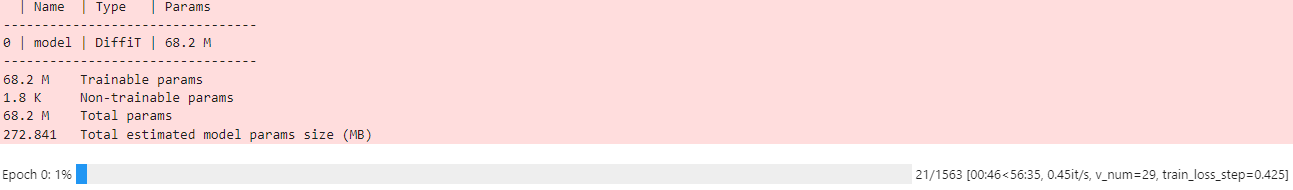


note that since the training time is not that low, I can't compare the result of one model against one other, but for the DiffiP (i.e. with PoolFormer) variant, we can expect results similar to the one obtained in the original paper about MetaFormers: [MetaFormer Is Actually What You Need for Vision](https://arxiv.org/abs/2111.11418)
